# Data Mining Project 
Ahmed - F2300082

Duha - A01193

Sayera - F2300198

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import json
from sklearn.cluster import DBSCAN
from sklearn.cluster import KMeans
from datetime import datetime
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score
import warnings
from sklearn.preprocessing import MinMaxScaler

warnings.filterwarnings('ignore')

# Set style for better-looking plots
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)

In [2]:
# Load all datasets
transactions = pd.read_csv('Input/transactions_2019data.csv')
cards = pd.read_csv('Input/cards_data.csv')
users = pd.read_csv('Input/users_data.csv')

# Load fraud labels
with open('Input/fraud_labels.json', 'r') as f:
    fraud_labels = json.load(f)

# Convert fraud labels to DataFrame for easier merging
fraud_df = pd.DataFrame(fraud_labels)
fraud_df.rename(columns={'fraud': 'is_fraud'}, inplace=True)
fraud_df['is_fraud'] = fraud_df['is_fraud'].map({'Yes': 1, 'No': 0})

print("Data loaded successfully!")
print(f"Transactions shape: {transactions.shape}")
print(f"Cards shape: {cards.shape}")
print(f"Users shape: {users.shape}")
print(f"Fraud labels shape: {fraud_df.shape}")

Data loaded successfully!
Transactions shape: (1159966, 12)
Cards shape: (6146, 13)
Users shape: (2000, 14)
Fraud labels shape: (777339, 2)


# Part 1: Exploratory Data Analysis (EDA)

## Objective
### Understand the dataset and identify initial patterns or anomalies.


## 1. Data Overview

### 1.1 Dataset Description

This section describes the dataset structure: number of rows, columns, types of variables, and memory usage.


In [3]:
# Merge fraud labels with transactions
transactions_with_fraud = transactions.merge(fraud_df, left_on='id', right_on='transaction_id', how='left')
transactions_with_fraud['is_fraud'] = transactions_with_fraud['is_fraud'].fillna(0).astype(int)

# Merge all datasets for comprehensive analysis
# First merge transactions with cards
# Note: transactions has 'card_id', cards has 'id'
df_merged = transactions_with_fraud.merge(cards, left_on='card_id', right_on='id', how='left', suffixes=('_trans', '_card'))

# Then merge with users
# Note: After first merge, 'client_id' from transactions becomes 'client_id_trans' due to suffixes
df_merged = df_merged.merge(users, left_on='client_id_trans', right_on='id', how='left', suffixes=('', '_user'))

print("Merged dataset shape:", df_merged.shape)
print("\nDataset Overview:")
print("=" * 50)


Merged dataset shape: (1159966, 41)

Dataset Overview:


In [4]:
# 1. TRANSACTIONS DATASET
print("1. TRANSACTIONS DATASET")
print("-" * 50)
print(f"Shape: {transactions.shape[0]:,} rows × {transactions.shape[1]} columns")
print(f"\nColumns: {list(transactions.columns)}")
print(f"\nData types:\n{transactions.dtypes}")
print(f"\nMemory usage: {transactions.memory_usage(deep=True).sum() / 1024**2:.2f} MB")
print("\n" + "=" * 50)


1. TRANSACTIONS DATASET
--------------------------------------------------
Shape: 1,159,966 rows × 12 columns

Columns: ['id', 'date', 'client_id', 'card_id', 'amount', 'use_chip', 'merchant_id', 'merchant_city', 'merchant_state', 'zip', 'mcc', 'errors']

Data types:
id                  int64
date               object
client_id           int64
card_id             int64
amount             object
use_chip           object
merchant_id         int64
merchant_city      object
merchant_state     object
zip               float64
mcc                 int64
errors             object
dtype: object

Memory usage: 415.04 MB



In [5]:
# Missing values for TRANSACTIONS DATASET
print("Missing values - TRANSACTIONS DATASET")
print("-" * 50)
print(transactions.isnull().sum())

Missing values - TRANSACTIONS DATASET
--------------------------------------------------
id                      0
date                    0
client_id               0
card_id                 0
amount                  0
use_chip                0
merchant_id             0
merchant_city           0
merchant_state     141071
zip                150932
mcc                     0
errors            1141312
dtype: int64


In [6]:
# 2. CARDS DATASET
print("2. CARDS DATASET")
print("-" * 50)
print(f"Shape: {cards.shape[0]:,} rows × {cards.shape[1]} columns")
print(f"\nColumns: {list(cards.columns)}")
print(f"\nData types:\n{cards.dtypes}")
print(f"\nMemory usage: {cards.memory_usage(deep=True).sum() / 1024**2:.2f} MB")
print("\n" + "=" * 50)

2. CARDS DATASET
--------------------------------------------------
Shape: 6,146 rows × 13 columns

Columns: ['id', 'client_id', 'card_brand', 'card_type', 'card_number', 'expires', 'cvv', 'has_chip', 'num_cards_issued', 'credit_limit', 'acct_open_date', 'year_pin_last_changed', 'card_on_dark_web']

Data types:
id                        int64
client_id                 int64
card_brand               object
card_type                object
card_number               int64
expires                  object
cvv                       int64
has_chip                 object
num_cards_issued          int64
credit_limit             object
acct_open_date           object
year_pin_last_changed     int64
card_on_dark_web         object
dtype: object

Memory usage: 2.51 MB



In [7]:
# Missing values for CARDS DATASET
print("Missing values - CARDS DATASET")
print("-" * 50)
print(cards.isnull().sum())


Missing values - CARDS DATASET
--------------------------------------------------
id                       0
client_id                0
card_brand               0
card_type                0
card_number              0
expires                  0
cvv                      0
has_chip                 0
num_cards_issued         0
credit_limit             0
acct_open_date           0
year_pin_last_changed    0
card_on_dark_web         0
dtype: int64


In [8]:
# 3. USERS DATASET
print("3. USERS DATASET")
print("-" * 50)
print(f"Shape: {users.shape[0]:,} rows × {users.shape[1]} columns")
print(f"\nColumns: {list(users.columns)}")
print(f"\nData types:\n{users.dtypes}")
print(f"\nMemory usage: {users.memory_usage(deep=True).sum() / 1024**2:.2f} MB")
print("\n" + "=" * 50)

3. USERS DATASET
--------------------------------------------------
Shape: 2,000 rows × 14 columns

Columns: ['id', 'current_age', 'retirement_age', 'birth_year', 'birth_month', 'gender', 'address', 'latitude', 'longitude', 'per_capita_income', 'yearly_income', 'total_debt', 'credit_score', 'num_credit_cards']

Data types:
id                     int64
current_age            int64
retirement_age         int64
birth_year             int64
birth_month            int64
gender                object
address               object
latitude             float64
longitude            float64
per_capita_income     object
yearly_income         object
total_debt            object
credit_score           int64
num_credit_cards       int64
dtype: object

Memory usage: 0.68 MB



In [9]:
# Missing values for USERS DATASET
print("Missing values - USERS DATASET")
print("-" * 50)
print(users.isnull().sum())


Missing values - USERS DATASET
--------------------------------------------------
id                   0
current_age          0
retirement_age       0
birth_year           0
birth_month          0
gender               0
address              0
latitude             0
longitude            0
per_capita_income    0
yearly_income        0
total_debt           0
credit_score         0
num_credit_cards     0
dtype: int64


In [10]:
# 4. FRAUD LABELS
print("4. FRAUD LABELS")
print("-" * 50)
print(f"Shape: {fraud_df.shape[0]:,} rows × {fraud_df.shape[1]} columns")
print(f"Fraud rate: {fraud_df['is_fraud'].mean()*100:.2f}%")
print(f"Non-fraud: {(fraud_df['is_fraud']==0).sum():,}")
print(f"Fraud: {(fraud_df['is_fraud']==1).sum():,}")


4. FRAUD LABELS
--------------------------------------------------
Shape: 777,339 rows × 2 columns
Fraud rate: 0.17%
Non-fraud: 775,979
Fraud: 1,360


### 1.2 Descriptive Statistics

#### 1.2.1 Numerical Features Summary

In [11]:
# Clean and prepare numerical columns for analysis
# Convert amount to numeric (remove $ and commas)
transactions['amount_clean'] = transactions['amount'].str.replace('$', '').str.replace(',', '').astype(float)

# Convert date to datetime
transactions['date'] = pd.to_datetime(transactions['date'])

# Extract date features
transactions['year'] = transactions['date'].dt.year
transactions['month'] = transactions['date'].dt.month
transactions['day'] = transactions['date'].dt.day
transactions['hour'] = transactions['date'].dt.hour
transactions['day_of_week'] = transactions['date'].dt.day_name()

print("TRANSACTIONS - Numerical Features Summary")
print("=" * 60)
print(transactions[['amount_clean']].describe())
print("\n" + "=" * 60)


TRANSACTIONS - Numerical Features Summary
       amount_clean
count  1.159966e+06
mean   4.265216e+01
std    8.058645e+01
min   -5.000000e+02
25%    8.880000e+00
50%    2.886000e+01
75%    6.314000e+01
max    6.613440e+03



In [12]:
# Clean cards data
cards['credit_limit_clean'] = cards['credit_limit'].str.replace('$', '').str.replace(',', '').astype(float)

print("CARDS - Numerical Features Summary")
print("=" * 60)
print(cards[['credit_limit_clean', 'num_cards_issued']].describe())
print("\n" + "=" * 60)


CARDS - Numerical Features Summary
       credit_limit_clean  num_cards_issued
count         6146.000000       6146.000000
mean         14347.493980          1.503091
std          12014.463884          0.519191
min              0.000000          1.000000
25%           7042.750000          1.000000
50%          12592.500000          1.000000
75%          19156.500000          2.000000
max         151223.000000          3.000000



In [13]:
# Clean users data
users['per_capita_income_clean'] = users['per_capita_income'].str.replace('$', '').str.replace(',', '').astype(float)
users['yearly_income_clean'] = users['yearly_income'].str.replace('$', '').str.replace(',', '').astype(float)
users['total_debt_clean'] = users['total_debt'].str.replace('$', '').str.replace(',', '').astype(float)

print("USERS - Numerical Features Summary")
print("=" * 60)
print(users[['current_age', 'retirement_age', 'per_capita_income_clean', 
             'yearly_income_clean', 'total_debt_clean', 'credit_score', 'num_credit_cards']].describe())
print("\n" + "=" * 60)


USERS - Numerical Features Summary
       current_age  retirement_age  per_capita_income_clean  \
count  2000.000000     2000.000000              2000.000000   
mean     45.391500       66.237500             23141.928000   
std      18.414092        3.628867             11324.137358   
min      18.000000       50.000000                 0.000000   
25%      30.000000       65.000000             16824.500000   
50%      44.000000       66.000000             20581.000000   
75%      58.000000       68.000000             26286.000000   
max     101.000000       79.000000            163145.000000   

       yearly_income_clean  total_debt_clean  credit_score  num_credit_cards  
count          2000.000000       2000.000000   2000.000000       2000.000000  
mean          45715.882000      63709.694000    709.734500          3.073000  
std           22992.615456      52254.453421     67.221949          1.637379  
min               1.000000          0.000000    480.000000          1.000000  
25

#### 1.2.2 Categorical Features Summary

In [14]:
print("TRANSACTIONS - Categorical Features Summary")
print("=" * 60)
print(transactions[['use_chip', 'merchant_state', 'merchant_city']].describe())

TRANSACTIONS - Categorical Features Summary
                use_chip merchant_state merchant_city
count            1159966        1018895       1159966
unique                 3            112          7123
top     Chip Transaction             CA        ONLINE
freq              823180         124019        141071


In [15]:
print("CARDS - Categorical Features Summary")
print("=" * 60)
print(cards[['card_brand', 'card_type', 'has_chip', 'card_on_dark_web']].describe())

CARDS - Categorical Features Summary
        card_brand card_type has_chip card_on_dark_web
count         6146      6146     6146             6146
unique           4         3        2                1
top     Mastercard     Debit      YES               No
freq          3209      3511     5500             6146


In [16]:
print("USERS - Categorical Features Summary")
print("=" * 60)
print(users[['gender']].describe())

USERS - Categorical Features Summary
        gender
count     2000
unique       2
top     Female
freq      1016


### 1.3 Data Visualization


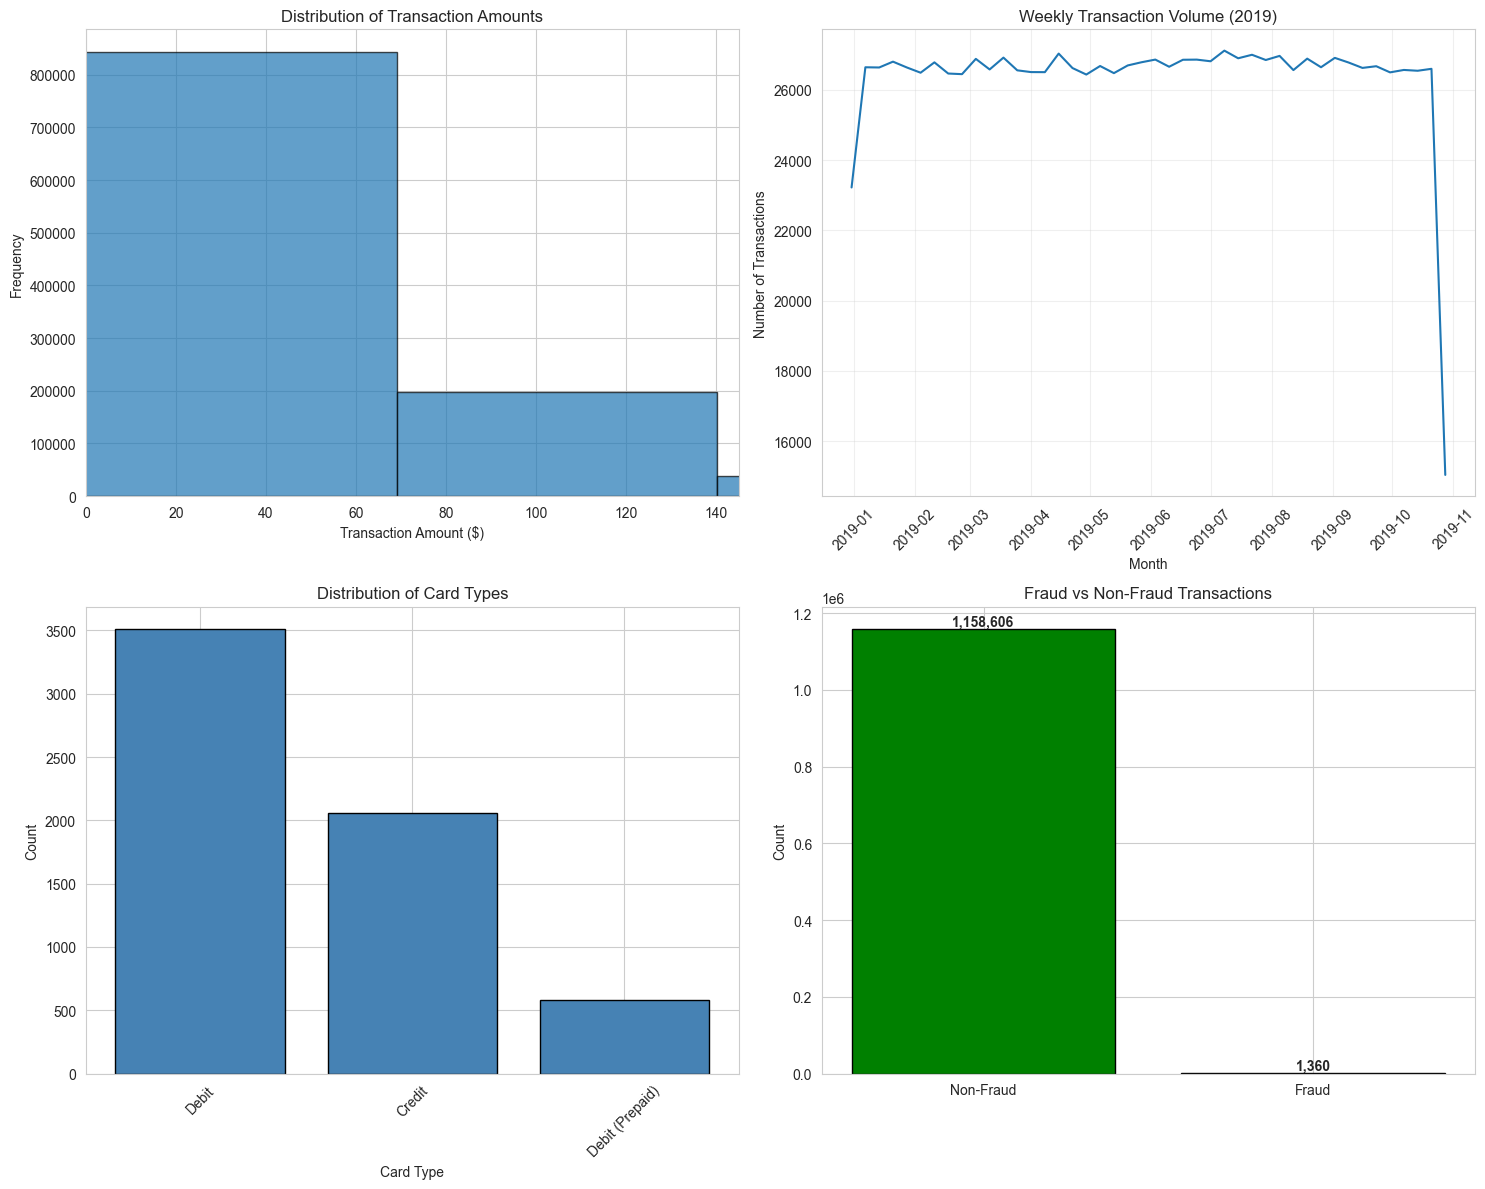

In [17]:
# Overview visualizations
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# 1. Transaction amount distribution
axes[0, 0].hist(transactions['amount_clean'], bins=100, edgecolor='black', alpha=0.7)
axes[0, 0].set_xlabel('Transaction Amount ($)')
axes[0, 0].set_ylabel('Frequency')
axes[0, 0].set_title('Distribution of Transaction Amounts')
axes[0, 0].set_xlim(0, transactions['amount_clean'].quantile(0.95))  # Remove extreme outliers for better visualization

# 2. Transactions over time
# daily_transactions = transactions.groupby(transactions['date'].dt.date).size()
# axes[0, 1].plot(daily_transactions.index, daily_transactions.values, linewidth=1.5)
# axes[0, 1].set_xlabel('Date')
# axes[0, 1].set_ylabel('Number of Transactions')
# axes[0, 1].set_title('Daily Transaction Volume (2019)')
# axes[0, 1].tick_params(axis='x', rotation=45)

weekly_transactions = transactions.groupby(transactions['date'].dt.to_period('W')).size()
weekly_dates = weekly_transactions.index.to_timestamp()

axes[0, 1].plot(weekly_dates, weekly_transactions.values, linewidth=1.5)
axes[0, 1].set_xlabel('Month')
axes[0, 1].set_ylabel('Number of Transactions')
axes[0, 1].set_title('Weekly Transaction Volume (2019)')
axes[0, 1].tick_params(axis='x', rotation=45)
axes[0, 1].grid(True, alpha=0.3)

# Format x-axis to show year-month
import matplotlib.dates as mdates
axes[0, 1].xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
axes[0, 1].xaxis.set_major_locator(mdates.MonthLocator())


# 3. Card types distribution
card_type_counts = cards['card_type'].value_counts()
axes[1, 0].bar(card_type_counts.index, card_type_counts.values, color='steelblue', edgecolor='black')
axes[1, 0].set_xlabel('Card Type')
axes[1, 0].set_ylabel('Count')
axes[1, 0].set_title('Distribution of Card Types')
axes[1, 0].tick_params(axis='x', rotation=45)

# 4. Fraud vs Non-Fraud distribution
fraud_counts = transactions_with_fraud['is_fraud'].value_counts()
axes[1, 1].bar(['Non-Fraud', 'Fraud'], fraud_counts.values, color=['green', 'red'], edgecolor='black')
axes[1, 1].set_ylabel('Count')
axes[1, 1].set_title('Fraud vs Non-Fraud Transactions')
for i, v in enumerate(fraud_counts.values):
    axes[1, 1].text(i, v, f'{v:,}', ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.show()


### 1.4 Target Variable and Key Predictors

**Target Variable:** `is_fraud` - Binary classification (1 = Fraud, 0 = Non-Fraud)

**Key Predictors:**
- Transaction features: amount, merchant details, time, location
- Card features: card type, credit limit, card brand
- User features: demographics, income, credit score, debt


In [18]:
# Analyze target variable distribution
print("TARGET VARIABLE ANALYSIS")
print("=" * 50)
print(f"Total transactions with fraud labels: {transactions_with_fraud['is_fraud'].notna().sum():,}")
print(f"Fraud transactions: {transactions_with_fraud['is_fraud'].sum():,}")
print(f"Non-fraud transactions: {(transactions_with_fraud['is_fraud']==0).sum():,}")
print(f"Fraud rate: {transactions_with_fraud['is_fraud'].mean()*100:.2f}%")
print(f"Missing fraud labels: {transactions_with_fraud['is_fraud'].isna().sum():,}")

# Fraud by card type
fraud_by_card = df_merged.groupby('card_type')['is_fraud'].agg(['sum', 'count', 'mean']).sort_values('mean', ascending=False)
print("\nFraud Rate by Card Type:")
print(fraud_by_card)
# Create all necessary bins first
if 'yearly_income_clean' not in df_merged.columns:
    df_merged['yearly_income_clean'] = df_merged['yearly_income'].str.replace('$', '').str.replace(',', '').astype(float)
if 'total_debt_clean' not in df_merged.columns:
    df_merged['total_debt_clean'] = df_merged['total_debt'].str.replace('$', '').str.replace(',', '').astype(float)
if 'amount_clean' not in df_merged.columns:
    df_merged['amount_clean'] = df_merged['amount'].str.replace('$', '').str.replace(',', '').astype(float)
if 'credit_limit_clean' not in df_merged.columns:
    df_merged['credit_limit_clean'] = df_merged['credit_limit'].str.replace('$', '').str.replace(',', '').astype(float)

# Extract time features from date column
if 'hour' not in df_merged.columns:
    df_merged['hour'] = pd.to_datetime(df_merged['date']).dt.hour
if 'day_of_week' not in df_merged.columns:
    df_merged['day_of_week'] = pd.to_datetime(df_merged['date']).dt.day_name()
if 'is_online' not in df_merged.columns:
    df_merged['is_online'] = df_merged['use_chip'].apply(lambda x: 'Online' if x == 'Online Transaction' else 'Physical')

# Create age bins
df_merged['age_bin'] = pd.cut(df_merged['current_age'], 
                               bins=[0, 25, 35, 45, 55, 65, 75, 150], 
                               labels=['18-25', '26-35', '36-45', '46-55', '56-65', '66-75', '76+'])

# Create amount bins
df_merged['amount_bin'] = pd.cut(df_merged['amount_clean'], 
                                  bins=[0, 20, 40, 60, 100, 200, 10000], 
                                  labels=['$0-20', '$20-40', '$40-60', '$60-100', '$100-200', '$200+'])

# Create credit score bins
df_merged['credit_score_bin'] = pd.cut(df_merged['credit_score'], 
                                        bins=[0, 580, 670, 740, 800, 900],
                                        labels=['Poor (≤580)', 'Fair (581-670)', 'Good (671-740)', 
                                               'Very Good (741-800)', 'Excellent (800+)'])

# Create credit limit bins
df_merged['credit_limit_bin'] = pd.cut(df_merged['credit_limit_clean'], 
                                        bins=[0, 5000, 10000, 15000, 25000, 200000],
                                        labels=['$0-5K', '$5K-10K', '$10K-15K', '$15K-25K', '$25K+'])

# Create income and debt bins
df_merged['income_bin'] = pd.qcut(df_merged['yearly_income_clean'], q=5, duplicates='drop')
df_merged['debt_bin'] = pd.qcut(df_merged['total_debt_clean'], q=5, duplicates='drop')

# 1. Amount
fraud_by_amount = df_merged.groupby('amount_bin')['is_fraud'].agg(['sum', 'count', 'mean']).sort_values('mean', ascending=False)
print("\nFraud Rate by Amount:")
print(fraud_by_amount)

# 2. Merchant - MCC
fraud_by_mcc = df_merged.groupby('mcc')['is_fraud'].agg(['sum', 'count', 'mean']).sort_values('mean', ascending=False).head(10)
print("\nFraud Rate by MCC:")
print(fraud_by_mcc)

# 3. Time - Hour
fraud_by_hour = df_merged.groupby('hour')['is_fraud'].agg(['sum', 'count', 'mean']).sort_values('mean', ascending=False)
print("\nFraud Rate by Hour:")
print(fraud_by_hour)

# 3. Time - Day of Week
fraud_by_day = df_merged.groupby('day_of_week')['is_fraud'].agg(['sum', 'count', 'mean']).sort_values('mean', ascending=False)
print("\nFraud Rate by Day of Week:")
print(fraud_by_day)

# 4. Location
fraud_by_location = df_merged.groupby('is_online')['is_fraud'].agg(['sum', 'count', 'mean']).sort_values('mean', ascending=False)
print("\nFraud Rate by Location (Online vs Physical):")
print(fraud_by_location)

# 5. Card Type
fraud_by_card_type = df_merged.groupby('card_type')['is_fraud'].agg(['sum', 'count', 'mean']).sort_values('mean', ascending=False)
print("\nFraud Rate by Card Type:")
print(fraud_by_card_type)

# 6. Credit Limit
fraud_by_credit_limit = df_merged.groupby('credit_limit_bin')['is_fraud'].agg(['sum', 'count', 'mean']).sort_values('mean', ascending=False)
print("\nFraud Rate by Credit Limit:")
print(fraud_by_credit_limit)

# 7. Card Brand
fraud_by_brand = df_merged.groupby('card_brand')['is_fraud'].agg(['sum', 'count', 'mean']).sort_values('mean', ascending=False)
print("\nFraud Rate by Card Brand:")
print(fraud_by_brand)

# 8. Demographics - Age
fraud_by_age = df_merged.groupby('age_bin')['is_fraud'].agg(['sum', 'count', 'mean']).sort_values('mean', ascending=False)
print("\nFraud Rate by Age:")
print(fraud_by_age)

# 9. Income
fraud_by_income = df_merged.groupby('income_bin')['is_fraud'].agg(['sum', 'count', 'mean']).sort_values('mean', ascending=False)
print("\nFraud Rate by Income:")
print(fraud_by_income)

# 10. Credit Score
fraud_by_credit_score = df_merged.groupby('credit_score_bin')['is_fraud'].agg(['sum', 'count', 'mean']).sort_values('mean', ascending=False)
print("\nFraud Rate by Credit Score:")
print(fraud_by_credit_score)

# 11. Debt
fraud_by_debt = df_merged.groupby('debt_bin')['is_fraud'].agg(['sum', 'count', 'mean']).sort_values('mean', ascending=False)
print("\nFraud Rate by Debt:")
print(fraud_by_debt)

# Merchant City
fraud_by_city = df_merged.groupby('merchant_city')['is_fraud'].agg(['sum', 'count', 'mean']).sort_values('mean', ascending=False)
print("\nFraud Rate by Merchant City (Top 20):")
print(fraud_by_city.head(20))

# Merchant State
fraud_by_state = df_merged.groupby('merchant_state')['is_fraud'].agg(['sum', 'count', 'mean']).sort_values('mean', ascending=False)
print("\nFraud Rate by Merchant State:")
print(fraud_by_state)

TARGET VARIABLE ANALYSIS
Total transactions with fraud labels: 1,159,966
Fraud transactions: 1,360
Non-fraud transactions: 1,158,606
Fraud rate: 0.12%
Missing fraud labels: 0

Fraud Rate by Card Type:
                 sum   count      mean
card_type                             
Credit           562  353825  0.001588
Debit (Prepaid)   99   78240  0.001265
Debit            699  727901  0.000960

Fraud Rate by Amount:
            sum   count      mean
amount_bin                       
$200+       161   27308  0.005896
$100-200    181   95731  0.001891
$0-20       491  422399  0.001162
$60-100     187  185115  0.001010
$20-40      181  213517  0.000848
$40-60      127  158142  0.000803

Fraud Rate by MCC:
      sum  count      mean
mcc                       
5733    7     30  0.233333
5045   40    269  0.148699
3006    3     26  0.115385
3009    5     46  0.108696
5712   36    369  0.097561
5094   43    474  0.090717
3005    3     35  0.085714
3144    2     27  0.074074
3075    2     31  0

## 2. Univariate Analysis

### 2.1 Numerical Features - Distributions


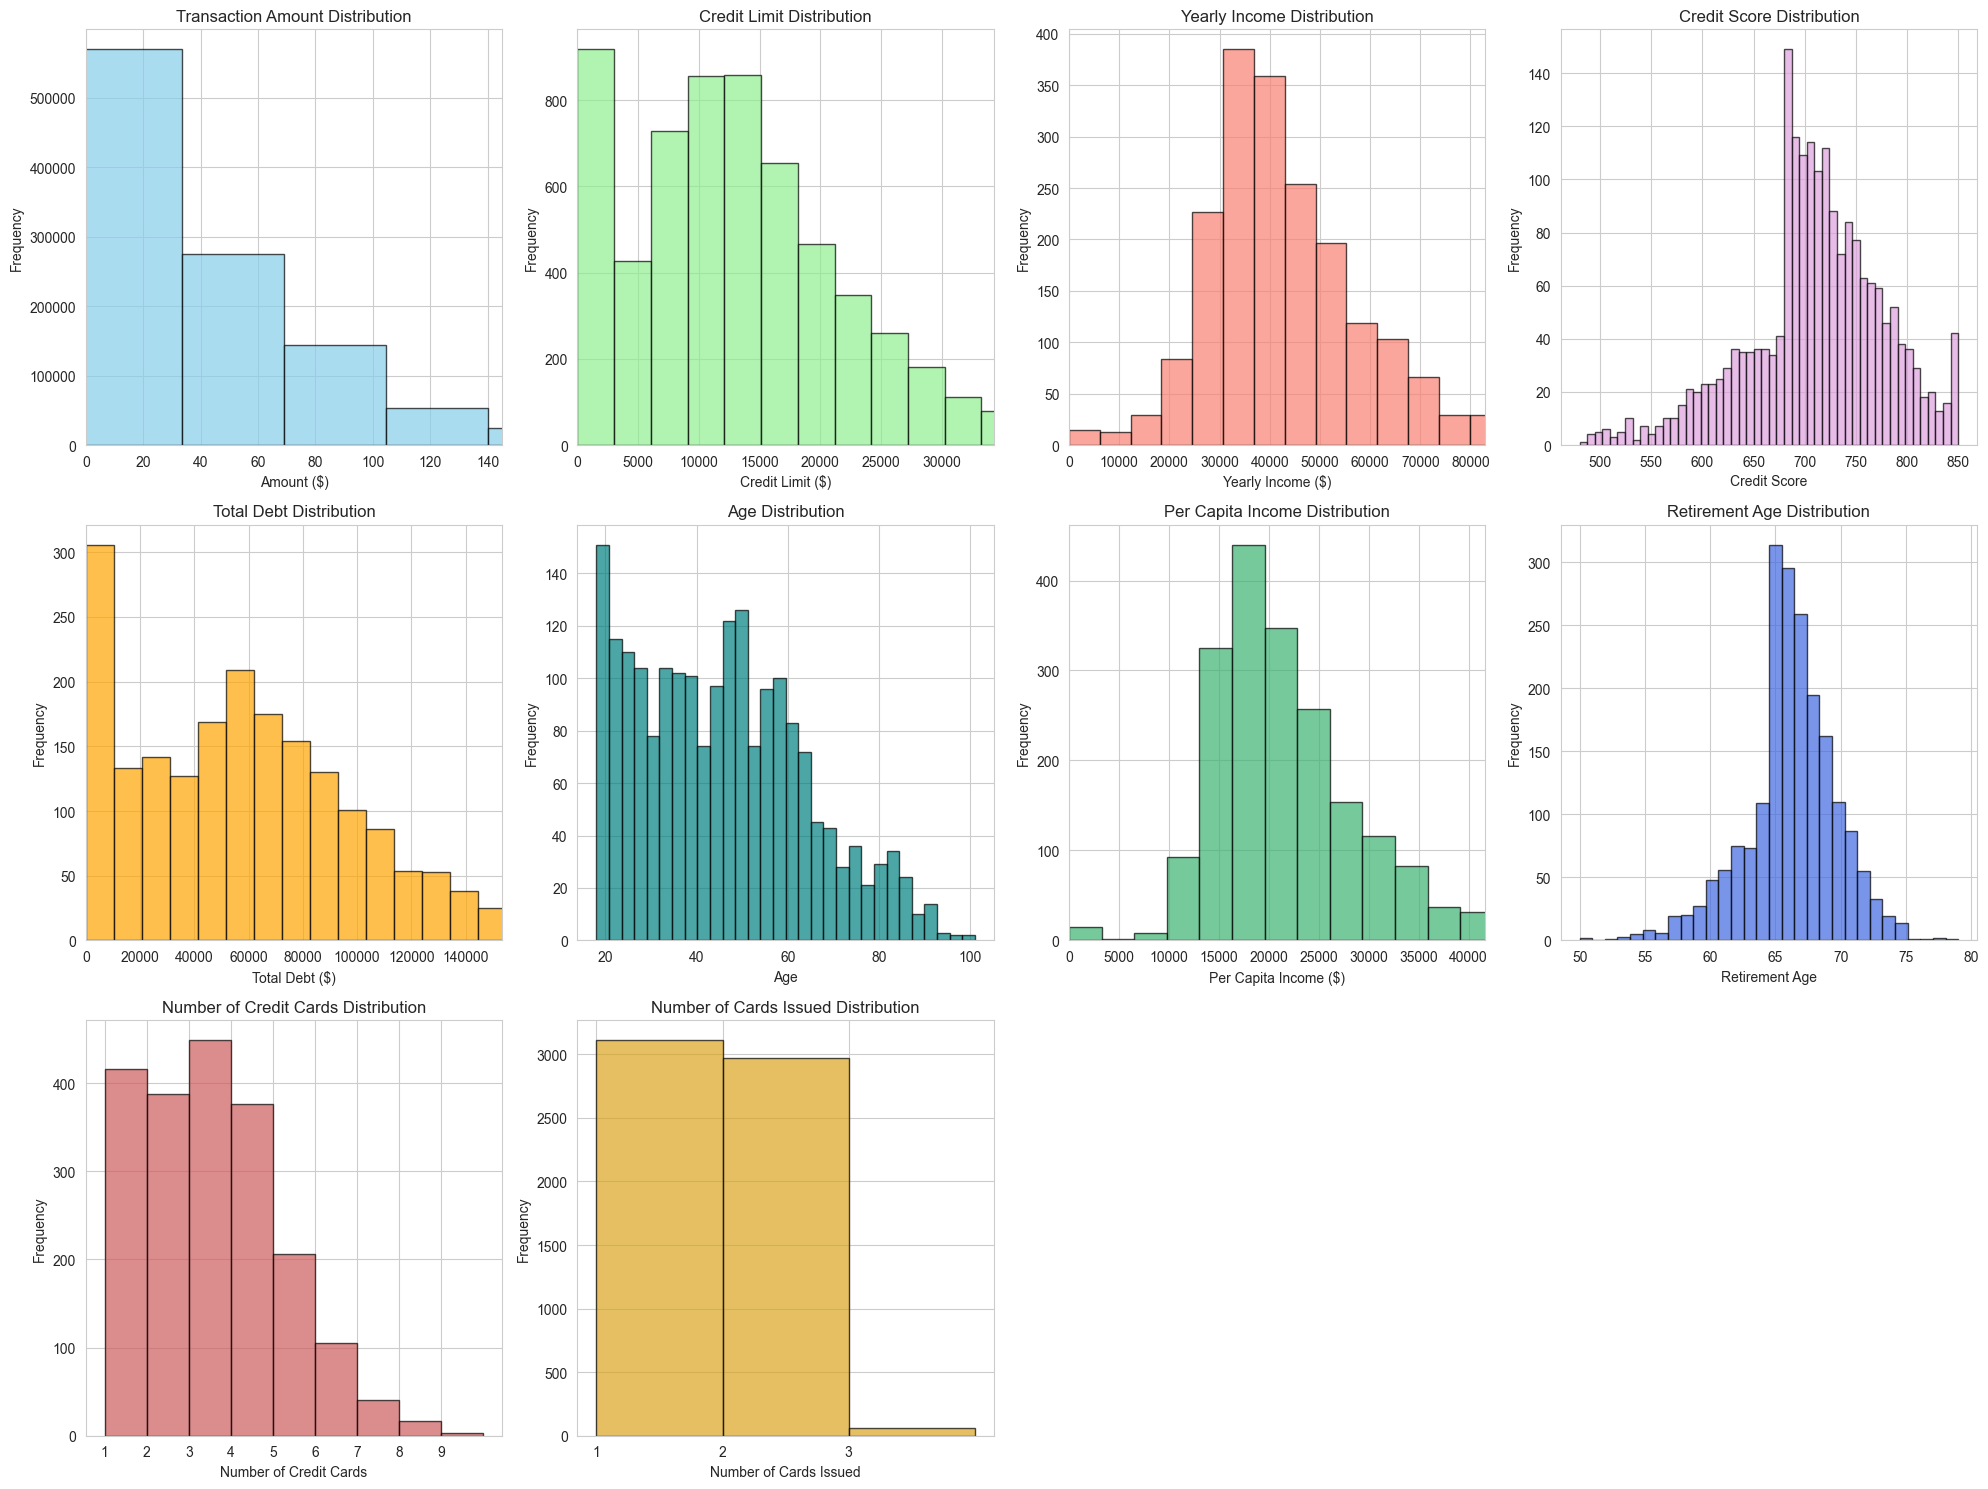

In [19]:
# Histograms for numerical features
fig, axes = plt.subplots(3, 4, figsize=(20, 15))

# Transaction amount
axes[0, 0].hist(transactions['amount_clean'], bins=200, edgecolor='black', alpha=0.7, color='skyblue')
axes[0, 0].set_xlabel('Amount ($)')
axes[0, 0].set_ylabel('Frequency')
axes[0, 0].set_title('Transaction Amount Distribution')
axes[0, 0].set_xlim(0, transactions['amount_clean'].quantile(0.95))

# Credit limit
axes[0, 1].hist(cards['credit_limit_clean'], bins=50, edgecolor='black', alpha=0.7, color='lightgreen')
axes[0, 1].set_xlabel('Credit Limit ($)')
axes[0, 1].set_ylabel('Frequency')
axes[0, 1].set_title('Credit Limit Distribution')
axes[0, 1].set_xlim(0, cards['credit_limit_clean'].quantile(0.95))

# Yearly income
axes[0, 2].hist(users['yearly_income_clean'], bins=50, edgecolor='black', alpha=0.7, color='salmon')
axes[0, 2].set_xlabel('Yearly Income ($)')
axes[0, 2].set_ylabel('Frequency')
axes[0, 2].set_title('Yearly Income Distribution')
axes[0, 2].set_xlim(0, users['yearly_income_clean'].quantile(0.95))

# Credit score
axes[0, 3].hist(users['credit_score'], bins=50, edgecolor='black', alpha=0.7, color='plum')
axes[0, 3].set_xlabel('Credit Score')
axes[0, 3].set_ylabel('Frequency')
axes[0, 3].set_title('Credit Score Distribution')

# Total debt
axes[1, 0].hist(users['total_debt_clean'], bins=50, edgecolor='black', alpha=0.7, color='orange')
axes[1, 0].set_xlabel('Total Debt ($)')
axes[1, 0].set_ylabel('Frequency')
axes[1, 0].set_title('Total Debt Distribution')
axes[1, 0].set_xlim(0, users['total_debt_clean'].quantile(0.95))

# Age
axes[1, 1].hist(users['current_age'], bins=30, edgecolor='black', alpha=0.7, color='teal')
axes[1, 1].set_xlabel('Age')
axes[1, 1].set_ylabel('Frequency')
axes[1, 1].set_title('Age Distribution')

# Per capita income
axes[1, 2].hist(users['per_capita_income_clean'], bins=50, edgecolor='black', alpha=0.7, color='mediumseagreen')
axes[1, 2].set_xlabel('Per Capita Income ($)')
axes[1, 2].set_ylabel('Frequency')
axes[1, 2].set_title('Per Capita Income Distribution')
axes[1, 2].set_xlim(0, users['per_capita_income_clean'].quantile(0.95))

# Retirement age
axes[1, 3].hist(users['retirement_age'], bins=30, edgecolor='black', alpha=0.7, color='royalblue')
axes[1, 3].set_xlabel('Retirement Age')
axes[1, 3].set_ylabel('Frequency')
axes[1, 3].set_title('Retirement Age Distribution')

# Number of credit cards
axes[2, 0].hist(users['num_credit_cards'], bins=range(1, users['num_credit_cards'].max() + 2), edgecolor='black', alpha=0.7, color='indianred')
axes[2, 0].set_xlabel('Number of Credit Cards')
axes[2, 0].set_ylabel('Frequency')
axes[2, 0].set_title('Number of Credit Cards Distribution')
axes[2, 0].set_xticks(range(1, users['num_credit_cards'].max() + 1))

# Number of cards issued
axes[2, 1].hist(cards['num_cards_issued'], bins=range(1, cards['num_cards_issued'].max() + 2), edgecolor='black', alpha=0.7, color='goldenrod')
axes[2, 1].set_xlabel('Number of Cards Issued')
axes[2, 1].set_ylabel('Frequency')
axes[2, 1].set_title('Number of Cards Issued Distribution')
axes[2, 1].set_xticks(range(1, cards['num_cards_issued'].max() + 1))

# Hide the remaining empty subplots
axes[2, 2].axis('off')
axes[2, 3].axis('off')

plt.tight_layout()
plt.show()

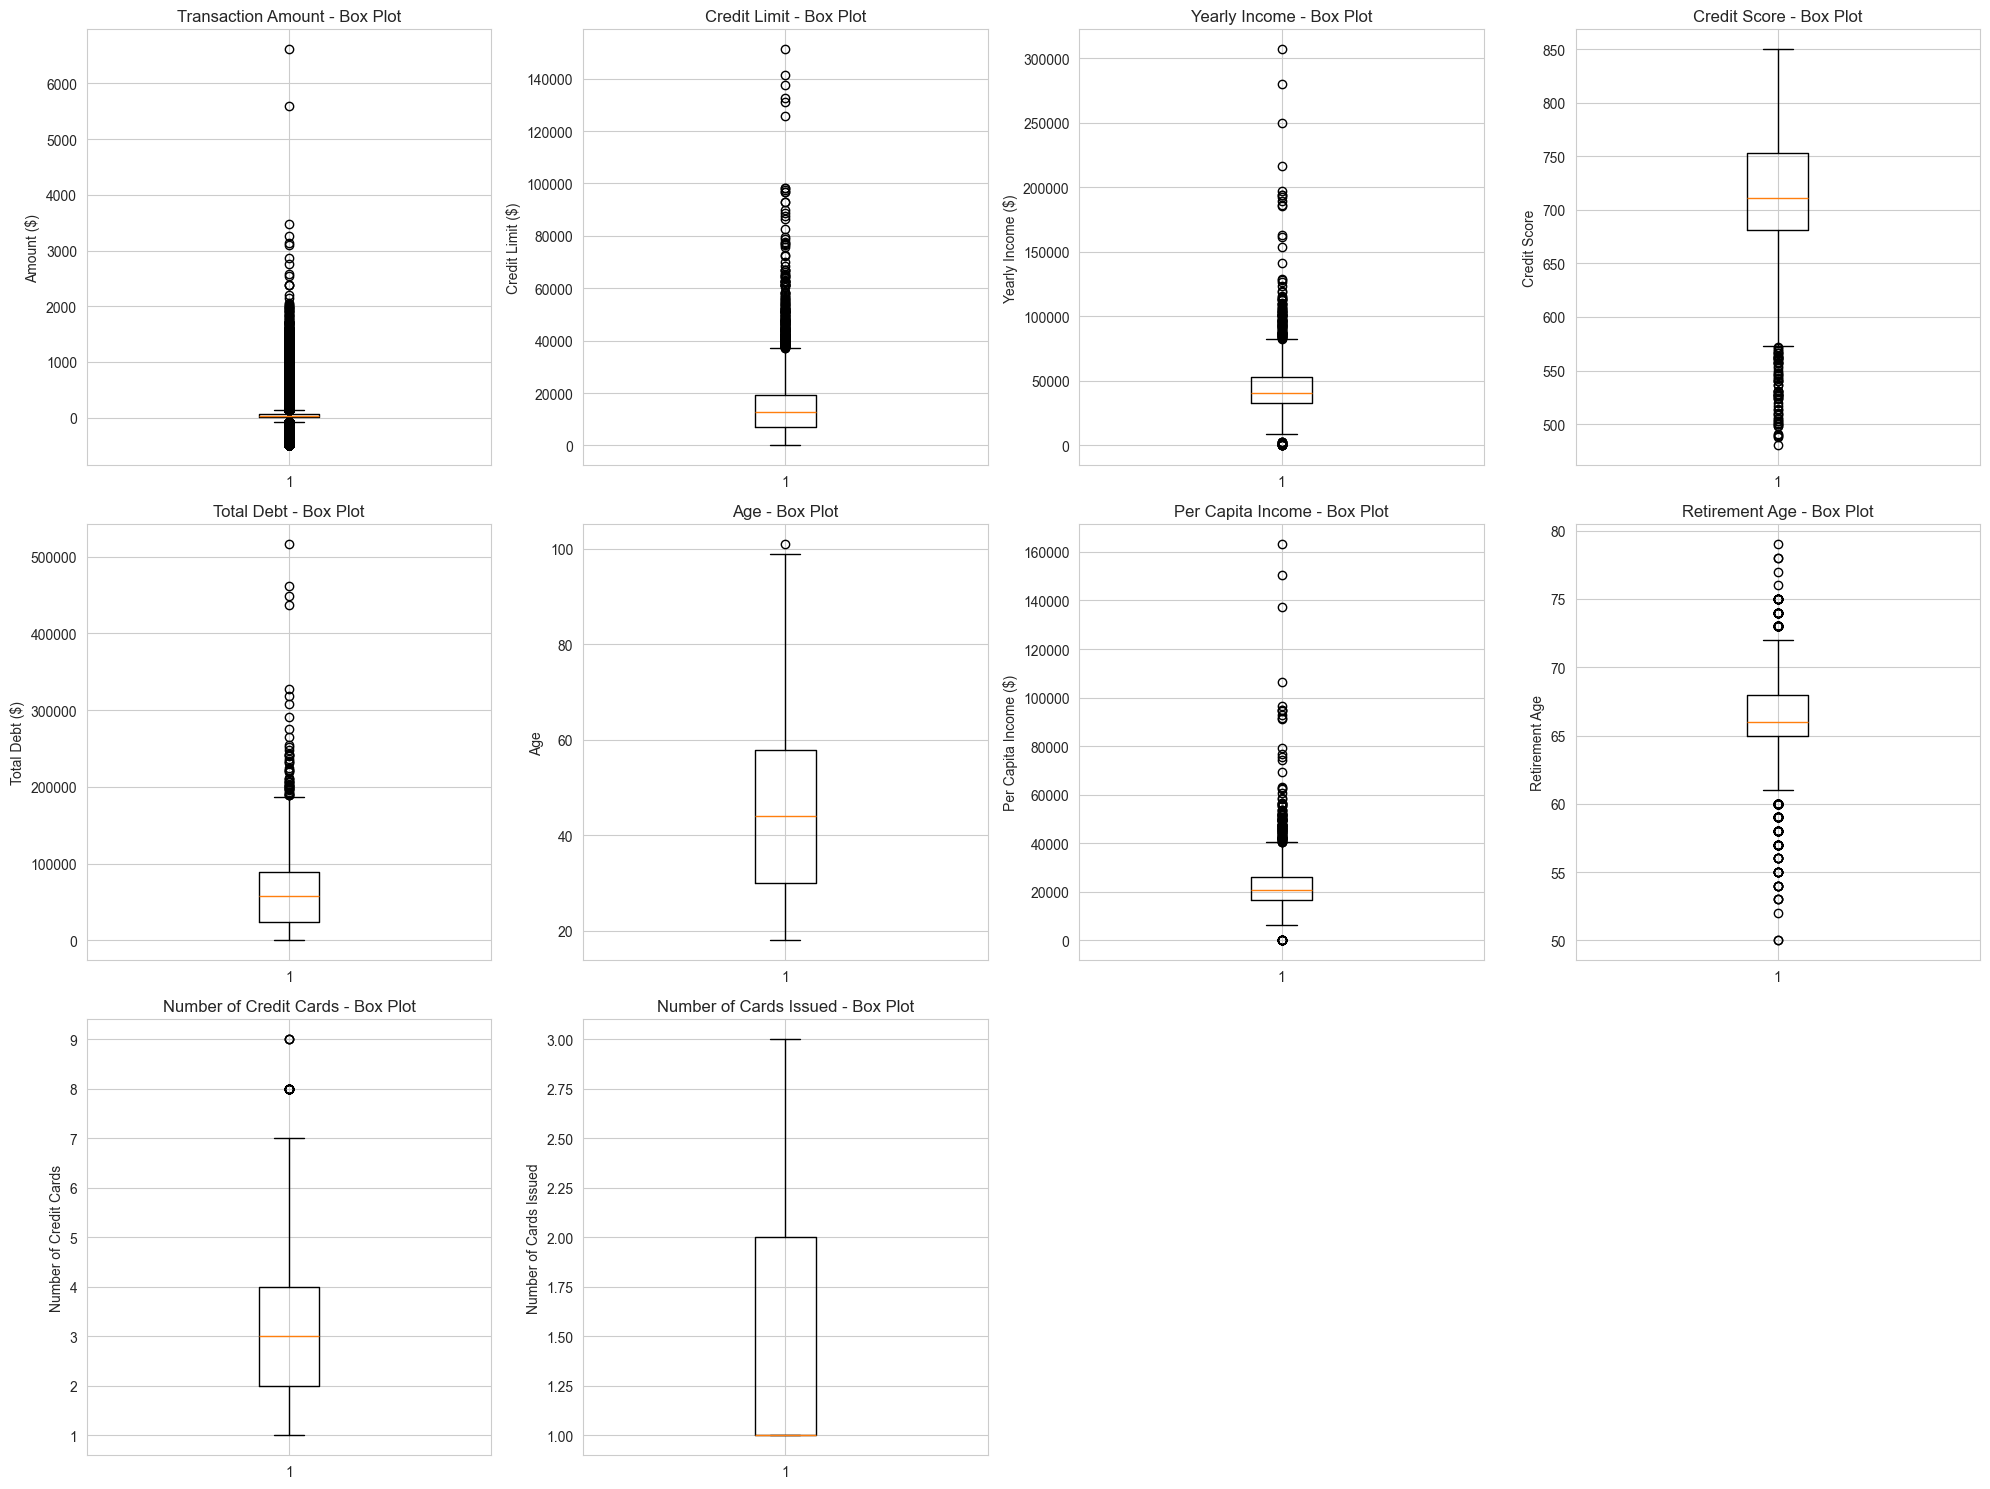

In [20]:
# Box plots for numerical features to identify outliers
fig, axes = plt.subplots(3, 4, figsize=(20, 15))

# Transaction amount
axes[0, 0].boxplot(transactions['amount_clean'], vert=True)
axes[0, 0].set_ylabel('Amount ($)')
axes[0, 0].set_title('Transaction Amount - Box Plot')

# Credit limit
axes[0, 1].boxplot(cards['credit_limit_clean'], vert=True)
axes[0, 1].set_ylabel('Credit Limit ($)')
axes[0, 1].set_title('Credit Limit - Box Plot')

# Yearly income
axes[0, 2].boxplot(users['yearly_income_clean'], vert=True)
axes[0, 2].set_ylabel('Yearly Income ($)')
axes[0, 2].set_title('Yearly Income - Box Plot')

# Credit score
axes[0, 3].boxplot(users['credit_score'], vert=True)
axes[0, 3].set_ylabel('Credit Score')
axes[0, 3].set_title('Credit Score - Box Plot')

# Total debt
axes[1, 0].boxplot(users['total_debt_clean'], vert=True)
axes[1, 0].set_ylabel('Total Debt ($)')
axes[1, 0].set_title('Total Debt - Box Plot')

# Age
axes[1, 1].boxplot(users['current_age'], vert=True)
axes[1, 1].set_ylabel('Age')
axes[1, 1].set_title('Age - Box Plot')

# Per capita income
axes[1, 2].boxplot(users['per_capita_income_clean'], vert=True)
axes[1, 2].set_ylabel('Per Capita Income ($)')
axes[1, 2].set_title('Per Capita Income - Box Plot')

# Retirement age
axes[1, 3].boxplot(users['retirement_age'], vert=True)
axes[1, 3].set_ylabel('Retirement Age')
axes[1, 3].set_title('Retirement Age - Box Plot')

# Number of credit cards
axes[2, 0].boxplot(users['num_credit_cards'], vert=True)
axes[2, 0].set_ylabel('Number of Credit Cards')
axes[2, 0].set_title('Number of Credit Cards - Box Plot')

# Number of cards issued
axes[2, 1].boxplot(cards['num_cards_issued'], vert=True)
axes[2, 1].set_ylabel('Number of Cards Issued')
axes[2, 1].set_title('Number of Cards Issued - Box Plot')

# Hide the remaining empty subplots
axes[2, 2].axis('off')
axes[2, 3].axis('off')

plt.tight_layout()
plt.show()

### 2.2 Categorical Features Analysis


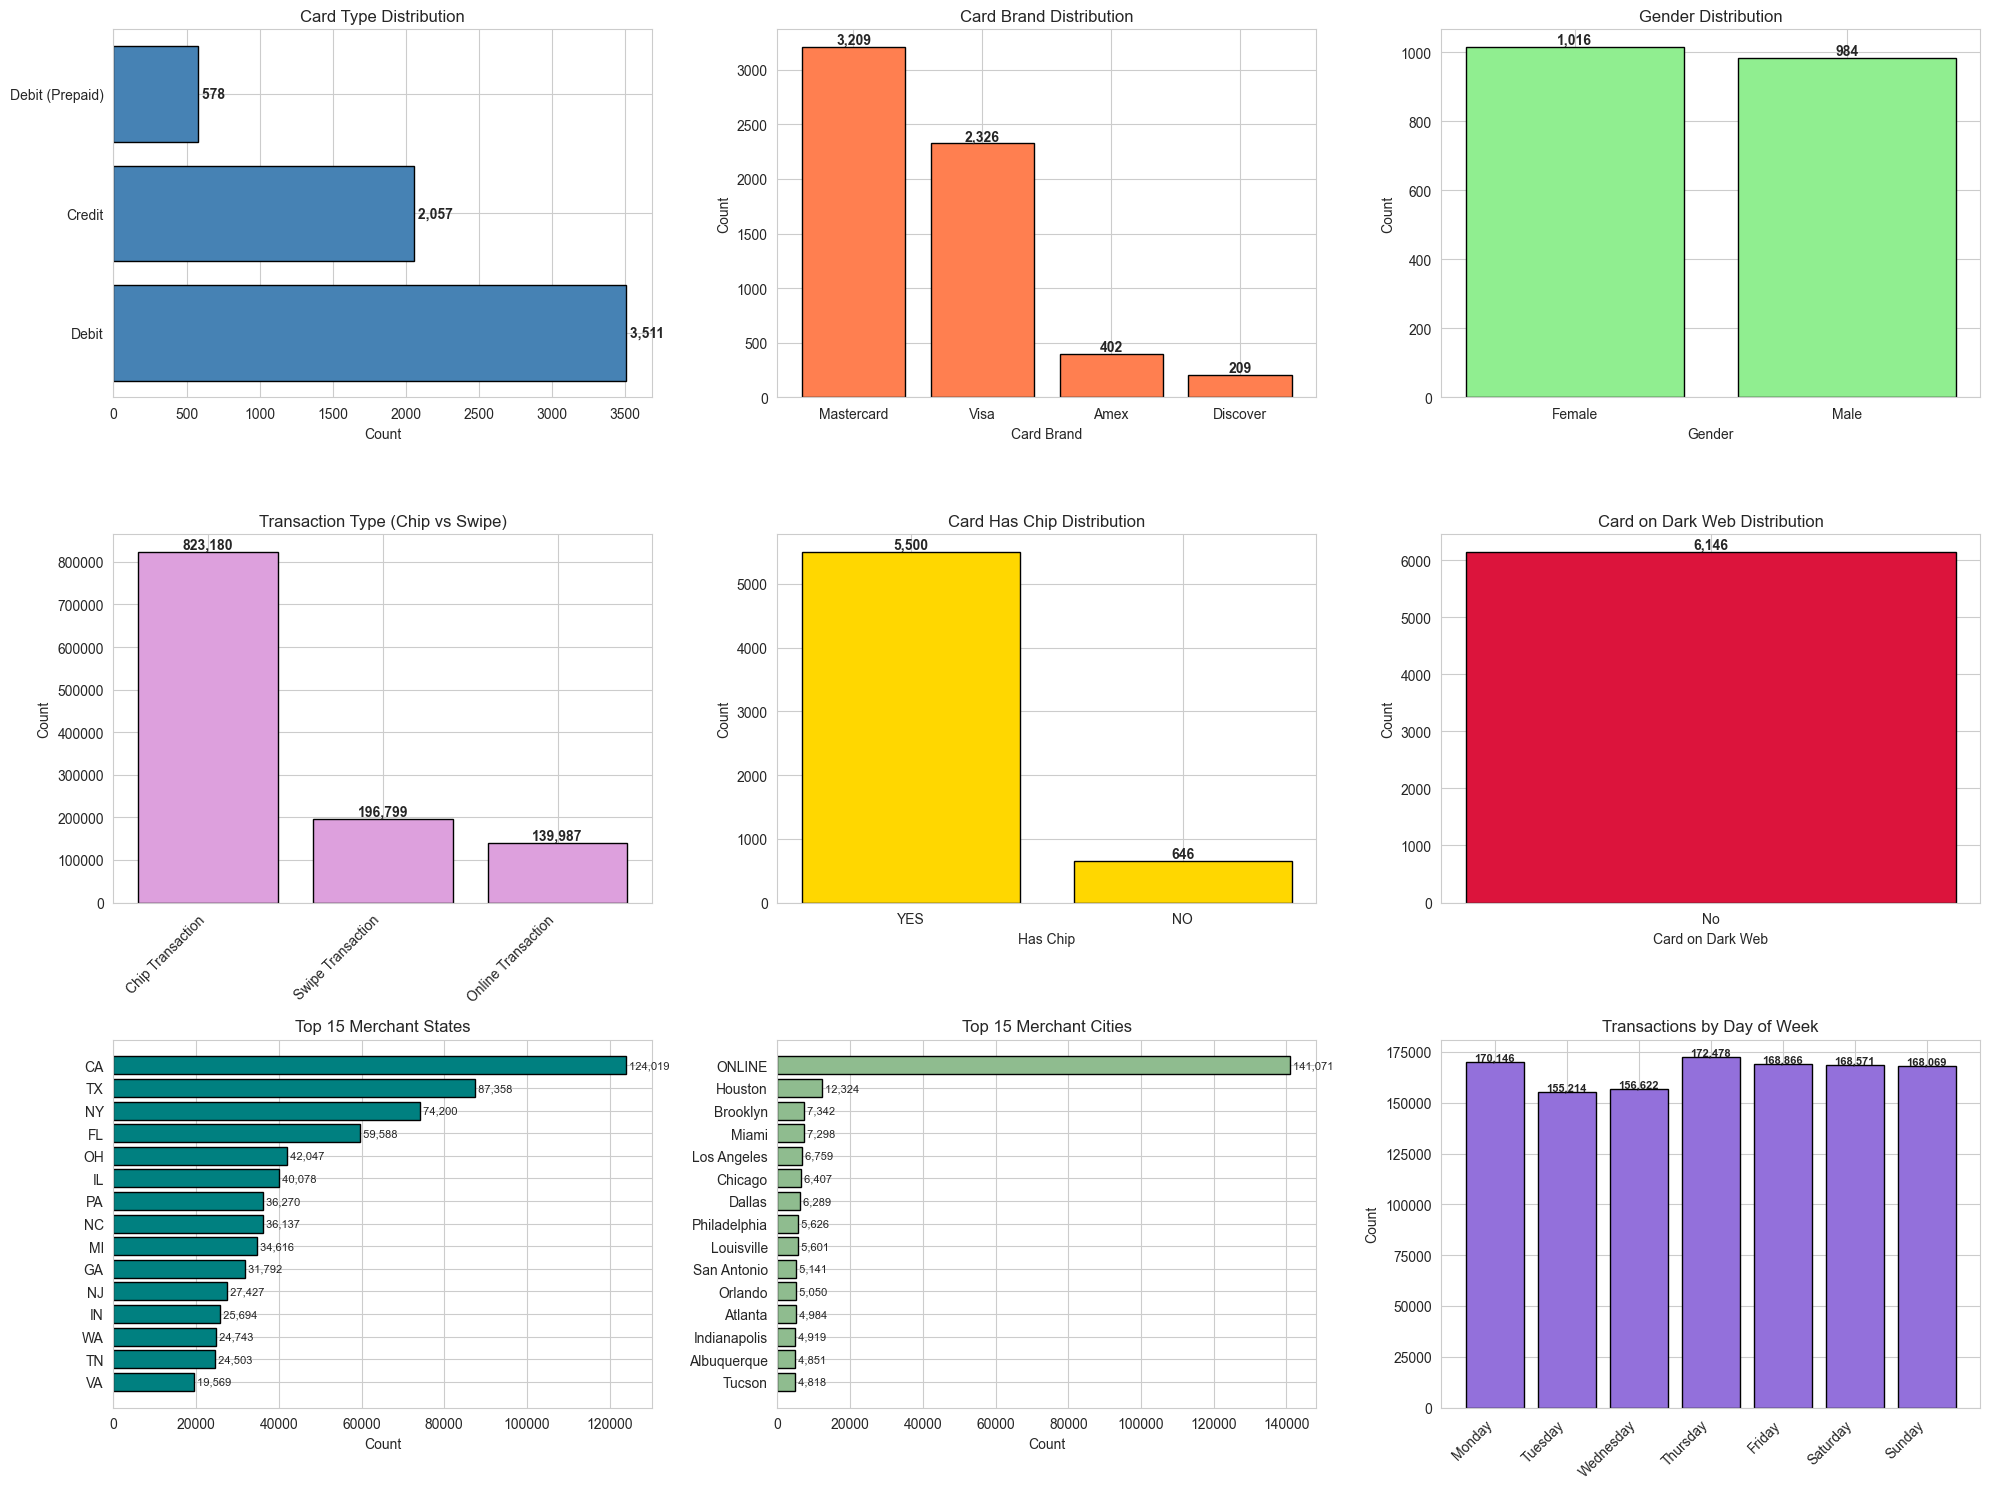

In [21]:
# Categorical features analysis
fig, axes = plt.subplots(3, 3, figsize=(20, 15))

# Card type
card_type_counts = cards['card_type'].value_counts()
axes[0, 0].barh(card_type_counts.index, card_type_counts.values, color='steelblue', edgecolor='black')
axes[0, 0].set_xlabel('Count')
axes[0, 0].set_title('Card Type Distribution')
for i, v in enumerate(card_type_counts.values):
    axes[0, 0].text(v, i, f' {v:,}', va='center', fontweight='bold')

# Card brand
card_brand_counts = cards['card_brand'].value_counts()
axes[0, 1].bar(card_brand_counts.index, card_brand_counts.values, color='coral', edgecolor='black')
axes[0, 1].set_xlabel('Card Brand')
axes[0, 1].set_ylabel('Count')
axes[0, 1].set_title('Card Brand Distribution')
for i, v in enumerate(card_brand_counts.values):
    axes[0, 1].text(i, v, f'{v:,}', ha='center', va='bottom', fontweight='bold')

# Gender
gender_counts = users['gender'].value_counts()
axes[0, 2].bar(gender_counts.index, gender_counts.values, color='lightgreen', edgecolor='black')
axes[0, 2].set_xlabel('Gender')
axes[0, 2].set_ylabel('Count')
axes[0, 2].set_title('Gender Distribution')
for i, v in enumerate(gender_counts.values):
    axes[0, 2].text(i, v, f'{v:,}', ha='center', va='bottom', fontweight='bold')

# Transaction type (use_chip)
use_chip_counts = transactions['use_chip'].value_counts()
axes[1, 0].bar(range(len(use_chip_counts)), use_chip_counts.values, color='plum', edgecolor='black')
axes[1, 0].set_xticks(range(len(use_chip_counts)))
axes[1, 0].set_xticklabels(use_chip_counts.index, rotation=45, ha='right')
axes[1, 0].set_ylabel('Count')
axes[1, 0].set_title('Transaction Type (Chip vs Swipe)')
for i, v in enumerate(use_chip_counts.values):
    axes[1, 0].text(i, v, f'{v:,}', ha='center', va='bottom', fontweight='bold')

# Has chip
has_chip_counts = cards['has_chip'].value_counts()
axes[1, 1].bar(has_chip_counts.index, has_chip_counts.values, color='gold', edgecolor='black')
axes[1, 1].set_xlabel('Has Chip')
axes[1, 1].set_ylabel('Count')
axes[1, 1].set_title('Card Has Chip Distribution')
for i, v in enumerate(has_chip_counts.values):
    axes[1, 1].text(i, v, f'{v:,}', ha='center', va='bottom', fontweight='bold')

# Card on dark web
card_darkweb_counts = cards['card_on_dark_web'].value_counts()
axes[1, 2].bar(card_darkweb_counts.index, card_darkweb_counts.values, color='crimson', edgecolor='black')
axes[1, 2].set_xlabel('Card on Dark Web')
axes[1, 2].set_ylabel('Count')
axes[1, 2].set_title('Card on Dark Web Distribution')
for i, v in enumerate(card_darkweb_counts.values):
    axes[1, 2].text(i, v, f'{v:,}', ha='center', va='bottom', fontweight='bold')

# Merchant State (Top 15)
merchant_state_counts = transactions['merchant_state'].value_counts().head(15)
axes[2, 0].barh(merchant_state_counts.index, merchant_state_counts.values, color='teal', edgecolor='black')
axes[2, 0].set_xlabel('Count')
axes[2, 0].set_title('Top 15 Merchant States')
axes[2, 0].invert_yaxis()
for i, v in enumerate(merchant_state_counts.values):
    axes[2, 0].text(v, i, f' {v:,}', va='center', fontsize=8)

# Merchant City (Top 15)
merchant_city_counts = transactions['merchant_city'].value_counts().head(15)
axes[2, 1].barh(merchant_city_counts.index, merchant_city_counts.values, color='darkseagreen', edgecolor='black')
axes[2, 1].set_xlabel('Count')
axes[2, 1].set_title('Top 15 Merchant Cities')
axes[2, 1].invert_yaxis()
for i, v in enumerate(merchant_city_counts.values):
    axes[2, 1].text(v, i, f' {v:,}', va='center', fontsize=8)

# Day of Week
day_of_week_counts = transactions['day_of_week'].value_counts()
day_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
day_of_week_ordered = day_of_week_counts.reindex(day_order)
axes[2, 2].bar(range(len(day_of_week_ordered)), day_of_week_ordered.values, color='mediumpurple', edgecolor='black')
axes[2, 2].set_xticks(range(len(day_of_week_ordered)))
axes[2, 2].set_xticklabels(day_of_week_ordered.index, rotation=45, ha='right')
axes[2, 2].set_ylabel('Count')
axes[2, 2].set_title('Transactions by Day of Week')
for i, v in enumerate(day_of_week_ordered.values):
    axes[2, 2].text(i, v, f'{v:,}', ha='center', va='bottom', fontsize=8, fontweight='bold')

plt.tight_layout()
plt.show()

In [22]:
# 1. Card Type - Frequency Table
print("1. Card Type:")
print(cards['card_type'].value_counts())
print(f"\nProportions:\n{cards['card_type'].value_counts(normalize=True) * 100}")


1. Card Type:
card_type
Debit              3511
Credit             2057
Debit (Prepaid)     578
Name: count, dtype: int64

Proportions:
card_type
Debit              57.126586
Credit             33.468923
Debit (Prepaid)     9.404491
Name: proportion, dtype: float64


In [23]:
# 2. Card Brand - Frequency Table
print("2. Card Brand:")
print(cards['card_brand'].value_counts())
print(f"\nProportions:\n{cards['card_brand'].value_counts(normalize=True) * 100}")


2. Card Brand:
card_brand
Mastercard    3209
Visa          2326
Amex           402
Discover       209
Name: count, dtype: int64

Proportions:
card_brand
Mastercard    52.212821
Visa          37.845753
Amex           6.540840
Discover       3.400586
Name: proportion, dtype: float64


In [24]:
# 3. Gender - Frequency Table
print("3. Gender:")
print(users['gender'].value_counts())
print(f"\nProportions:\n{users['gender'].value_counts(normalize=True) * 100}")


3. Gender:
gender
Female    1016
Male       984
Name: count, dtype: int64

Proportions:
gender
Female    50.8
Male      49.2
Name: proportion, dtype: float64


In [25]:
# 4. Transaction Type (Chip vs Swipe) - Frequency Table
print("4. Transaction Type (Chip vs Swipe):")
print(transactions['use_chip'].value_counts())
print(f"\nProportions:\n{transactions['use_chip'].value_counts(normalize=True) * 100}")


4. Transaction Type (Chip vs Swipe):
use_chip
Chip Transaction      823180
Swipe Transaction     196799
Online Transaction    139987
Name: count, dtype: int64

Proportions:
use_chip
Chip Transaction      70.965873
Swipe Transaction     16.965928
Online Transaction    12.068199
Name: proportion, dtype: float64


In [26]:
# 5. Day of Week (Transactions) - Frequency Table
print("5. Day of Week (Transactions):")
day_counts = transactions['day_of_week'].value_counts()
print(day_counts)
print(f"\nProportions:\n{(day_counts / day_counts.sum() * 100).round(2)}")


5. Day of Week (Transactions):
day_of_week
Thursday     172478
Monday       170146
Friday       168866
Saturday     168571
Sunday       168069
Wednesday    156622
Tuesday      155214
Name: count, dtype: int64

Proportions:
day_of_week
Thursday     14.87
Monday       14.67
Friday       14.56
Saturday     14.53
Sunday       14.49
Wednesday    13.50
Tuesday      13.38
Name: count, dtype: float64


## 3. Bivariate Analysis

### 3.1 Correlation Matrix


Available features for correlation matrix: 12
Features: ['amount_clean', 'credit_limit_clean', 'num_cards_issued', 'year_pin_last_changed', 'current_age', 'retirement_age', 'yearly_income_clean', 'total_debt_clean', 'credit_score', 'num_credit_cards', 'per_capita_income_clean', 'is_fraud']


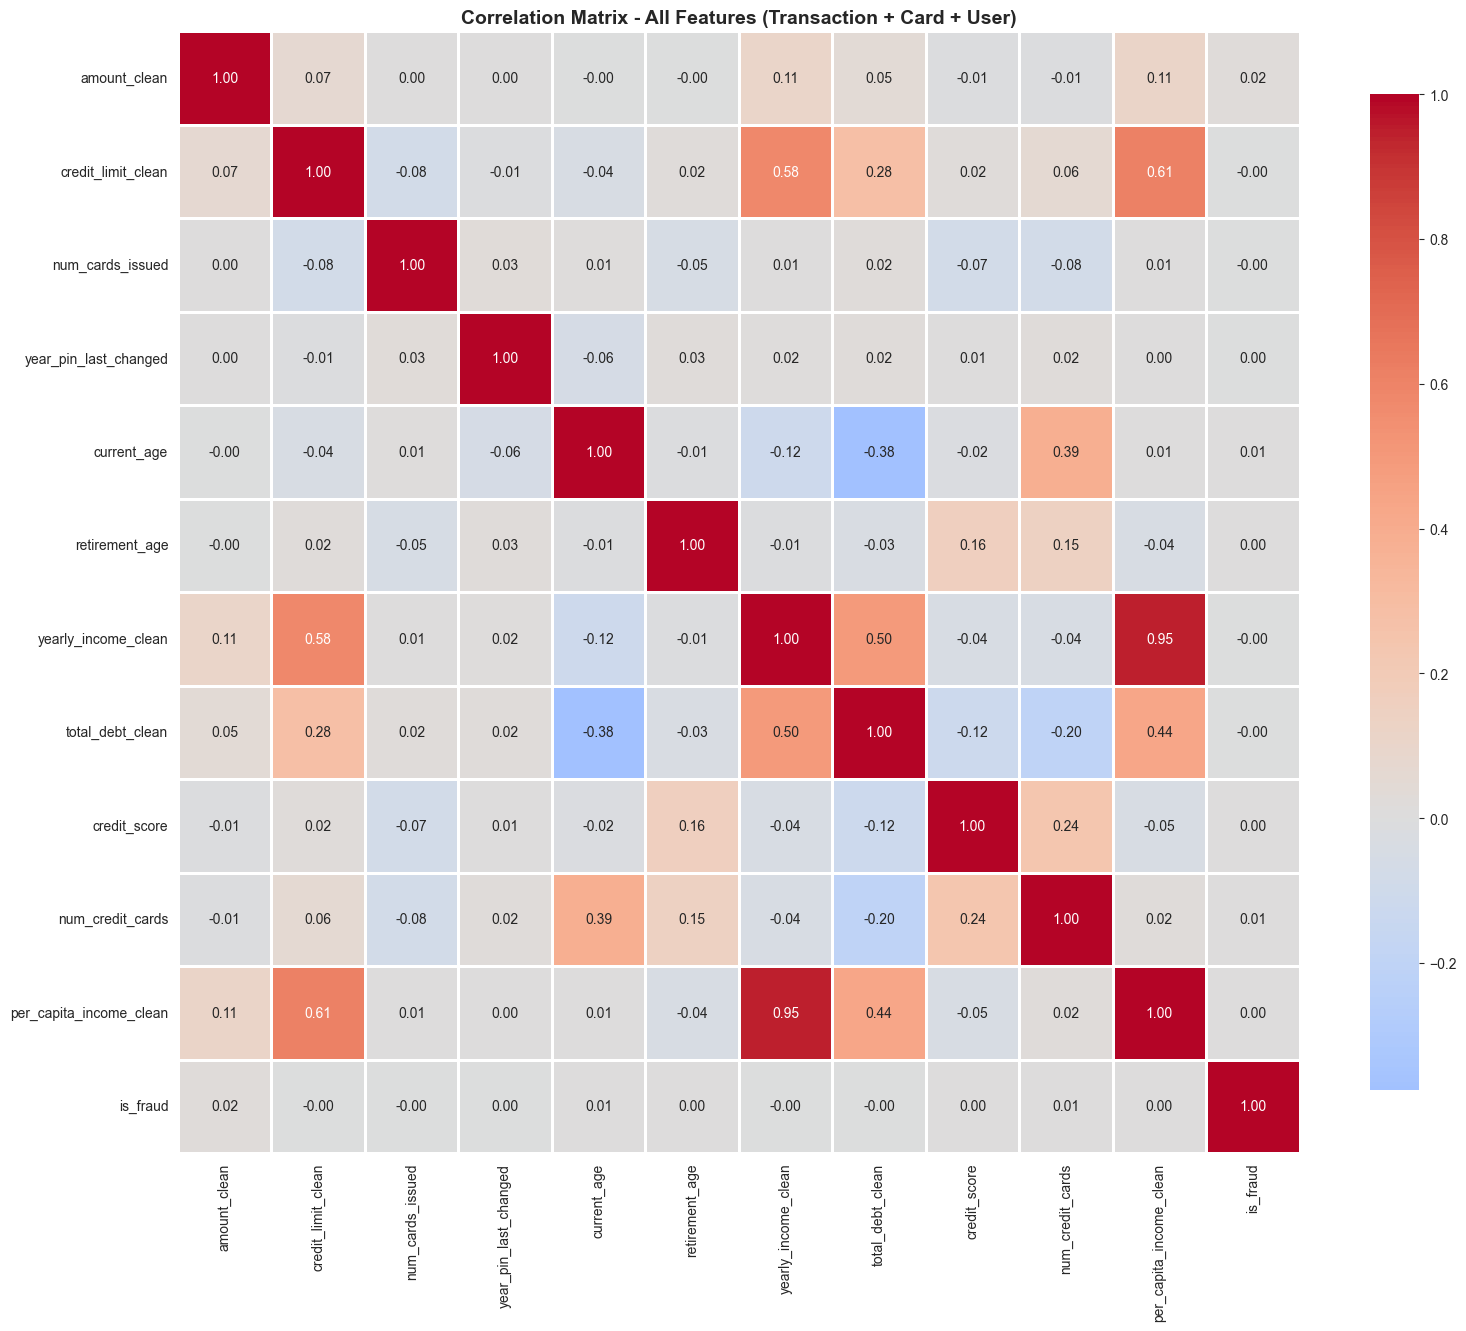

In [27]:
# Create cleaned columns in df_merged 
if 'yearly_income_clean' not in df_merged.columns:
    df_merged['yearly_income_clean'] = df_merged['yearly_income'].str.replace('$', '').str.replace(',', '').astype(float)
if 'total_debt_clean' not in df_merged.columns:
    df_merged['total_debt_clean'] = df_merged['total_debt'].str.replace('$', '').str.replace(',', '').astype(float)
if 'per_capita_income_clean' not in df_merged.columns:
    df_merged['per_capita_income_clean'] = df_merged['per_capita_income'].str.replace('$', '').str.replace(',', '').astype(float)
if 'credit_limit_clean' not in df_merged.columns:
    df_merged['credit_limit_clean'] = df_merged['credit_limit'].str.replace('$', '').str.replace(',', '').astype(float)
if 'amount_clean' not in df_merged.columns:
    df_merged['amount_clean'] = df_merged['amount'].str.replace('$', '').str.replace(',', '').astype(float)


# Select ALL numerical features from transaction, card, and user data
all_features = [
    # Transaction features
    'amount_clean', 
    # Card features
    'credit_limit_clean', 'num_cards_issued', 'year_pin_last_changed', 
    # User features
    'current_age', 'retirement_age', 'yearly_income_clean', 'total_debt_clean', 
    'credit_score', 'num_credit_cards', 'per_capita_income_clean', 'is_fraud'

]

# Filter to only include features that exist in df_merged
available_features = [f for f in all_features if f in df_merged.columns]

print(f"Available features for correlation matrix: {len(available_features)}")
print(f"Features: {available_features}")

# Prepare data for correlation analysis from df_merged
correlation_data = df_merged[available_features].copy()

# Calculate correlation matrix
corr_matrix = correlation_data.corr()

# Plot correlation heatmap
plt.figure(figsize=(16, 14))
sns.heatmap(corr_matrix, annot=True, fmt='.2f', cmap='coolwarm', center=0, 
            square=True, linewidths=1, cbar_kws={"shrink": 0.8})
plt.title('Correlation Matrix - All Features (Transaction + Card + User)', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()


### 3.2 Scatter plot for key relationships

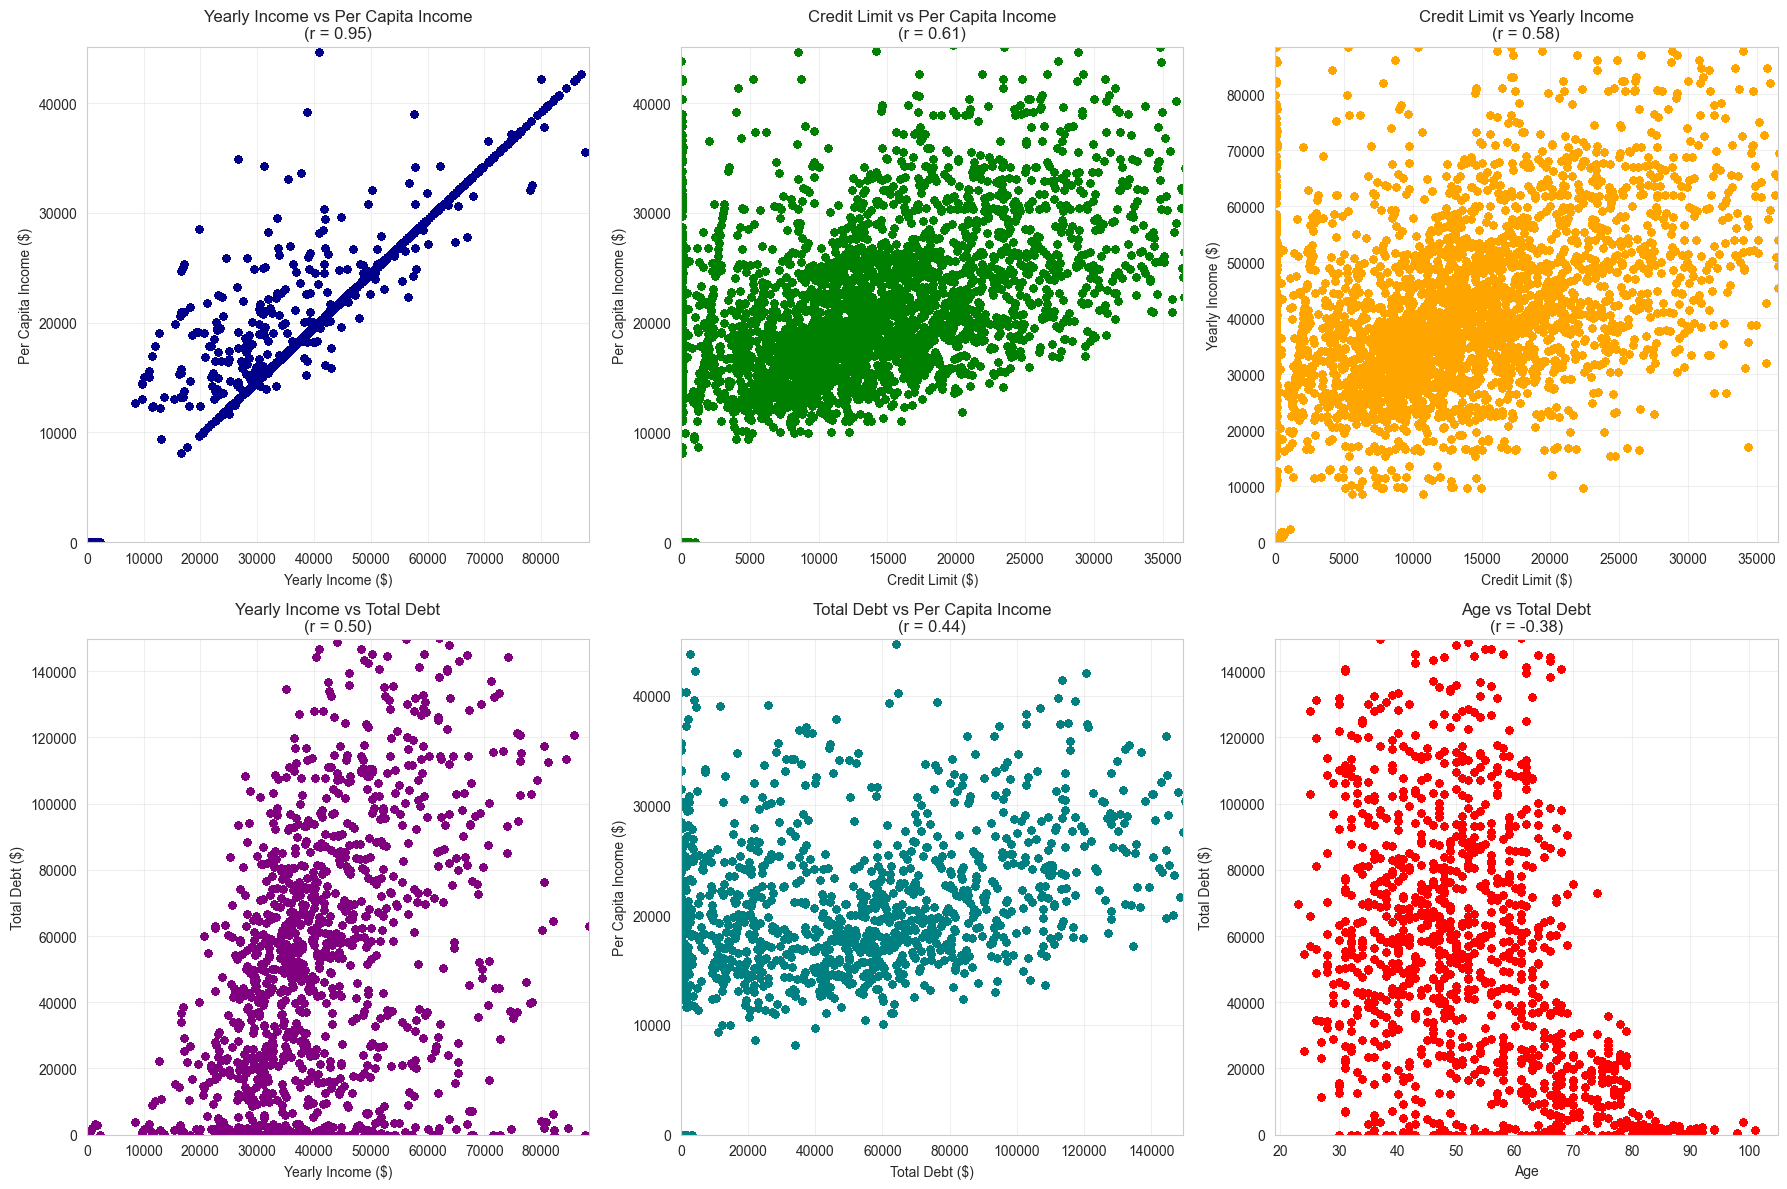

In [28]:
# Scatter plots for key relationships (high correlations)
fig, axes = plt.subplots(2, 3, figsize=(18, 12))

# 1. Yearly income vs Per capita income (VERY high correlation 0.95)
axes[0, 0].scatter(df_merged['yearly_income_clean'], df_merged['per_capita_income_clean'], alpha=0.5, s=20, color='darkblue')
axes[0, 0].set_xlabel('Yearly Income ($)')
axes[0, 0].set_ylabel('Per Capita Income ($)')
axes[0, 0].set_title('Yearly Income vs Per Capita Income\n(r = 0.95)')
axes[0, 0].set_xlim(0, df_merged['yearly_income_clean'].quantile(0.95))
axes[0, 0].set_ylim(0, df_merged['per_capita_income_clean'].quantile(0.95))
axes[0, 0].grid(True, alpha=0.3)

# 2. Credit limit vs Per capita income (high correlation 0.61)
axes[0, 1].scatter(df_merged['credit_limit_clean'], df_merged['per_capita_income_clean'], alpha=0.5, s=20, color='green')
axes[0, 1].set_xlabel('Credit Limit ($)')
axes[0, 1].set_ylabel('Per Capita Income ($)')
axes[0, 1].set_title('Credit Limit vs Per Capita Income\n(r = 0.61)')
axes[0, 1].set_xlim(0, df_merged['credit_limit_clean'].quantile(0.95))
axes[0, 1].set_ylim(0, df_merged['per_capita_income_clean'].quantile(0.95))
axes[0, 1].grid(True, alpha=0.3)

# 3. Credit limit vs Yearly income (high correlation 0.58)
axes[0, 2].scatter(df_merged['credit_limit_clean'], df_merged['yearly_income_clean'], alpha=0.5, s=20, color='orange')
axes[0, 2].set_xlabel('Credit Limit ($)')
axes[0, 2].set_ylabel('Yearly Income ($)')
axes[0, 2].set_title('Credit Limit vs Yearly Income\n(r = 0.58)')
axes[0, 2].set_xlim(0, df_merged['credit_limit_clean'].quantile(0.95))
axes[0, 2].set_ylim(0, df_merged['yearly_income_clean'].quantile(0.95))
axes[0, 2].grid(True, alpha=0.3)

# 4. Yearly income vs Total debt (high correlation 0.50)
axes[1, 0].scatter(df_merged['yearly_income_clean'], df_merged['total_debt_clean'], alpha=0.5, s=20, color='purple')
axes[1, 0].set_xlabel('Yearly Income ($)')
axes[1, 0].set_ylabel('Total Debt ($)')
axes[1, 0].set_title('Yearly Income vs Total Debt\n(r = 0.50)')
axes[1, 0].set_xlim(0, df_merged['yearly_income_clean'].quantile(0.95))
axes[1, 0].set_ylim(0, df_merged['total_debt_clean'].quantile(0.95))
axes[1, 0].grid(True, alpha=0.3)

# 5. Total debt vs Per capita income (correlation 0.44)
axes[1, 1].scatter(df_merged['total_debt_clean'], df_merged['per_capita_income_clean'], alpha=0.5, s=20, color='teal')
axes[1, 1].set_xlabel('Total Debt ($)')
axes[1, 1].set_ylabel('Per Capita Income ($)')
axes[1, 1].set_title('Total Debt vs Per Capita Income\n(r = 0.44)')
axes[1, 1].set_xlim(0, df_merged['total_debt_clean'].quantile(0.95))
axes[1, 1].set_ylim(0, df_merged['per_capita_income_clean'].quantile(0.95))
axes[1, 1].grid(True, alpha=0.3)

# 6. Age vs Total debt (negative correlation -0.38)
axes[1, 2].scatter(df_merged['current_age'], df_merged['total_debt_clean'], alpha=0.5, s=20, color='red')
axes[1, 2].set_xlabel('Age')
axes[1, 2].set_ylabel('Total Debt ($)')
axes[1, 2].set_title('Age vs Total Debt\n(r = -0.38)')
axes[1, 2].set_ylim(0, df_merged['total_debt_clean'].quantile(0.95))
axes[1, 2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

### 3.3 Grouped Summaries


In [29]:
# Prepare data for grouped summaries
# Create amount_clean in df_merged if it doesn't exist
if 'amount_clean' not in df_merged.columns:
    # Clean the amount column (remove $ and commas, convert to float)
    df_merged['amount_clean'] = df_merged['amount'].str.replace('$', '').str.replace(',', '').astype(float)

# Create date-related columns in df_merged if they don't exist
if 'day_of_week' not in df_merged.columns or 'hour' not in df_merged.columns:
    # Extract date features
    if 'day_of_week' not in df_merged.columns:
        df_merged['day_of_week'] = df_merged['date'].dt.day_name()
    if 'hour' not in df_merged.columns:
        df_merged['hour'] = df_merged['date'].dt.hour

print("Data prepared for grouped summaries.")


Data prepared for grouped summaries.


In [30]:
# 1. Average Transaction Amount by Card Type
print("1. Average Transaction Amount by Card Type:")
avg_amount_by_card = df_merged.groupby('card_type')['amount_clean'].agg(['mean', 'median', 'count']).sort_values('mean', ascending=False)
print(avg_amount_by_card)


1. Average Transaction Amount by Card Type:
                      mean  median   count
card_type                                 
Credit           54.741239   39.09  353825
Debit            39.029538   26.69  727901
Debit (Prepaid)  21.684517   17.30   78240


In [31]:
# 2. Average Transaction Amount by Card Brand
print("2. Average Transaction Amount by Card Brand:")
avg_amount_by_brand = df_merged.groupby('card_brand')['amount_clean'].agg(['mean', 'median', 'count']).sort_values('mean', ascending=False)
print(avg_amount_by_brand)


2. Average Transaction Amount by Card Brand:
                 mean  median   count
card_brand                           
Amex        55.088928   39.00   72733
Discover    54.715532   37.85   29722
Visa        43.786886   29.81  431822
Mastercard  39.850272   26.85  625689


In [32]:
# 3. Fraud Rate by Card Type
print("3. Fraud Rate by Card Type:")
fraud_by_card_type = df_merged.groupby('card_type')['is_fraud'].agg(['sum', 'count', 'mean']).sort_values('mean', ascending=False)
fraud_by_card_type.columns = ['Fraud_Count', 'Total_Count', 'Fraud_Rate']
fraud_by_card_type['Fraud_Rate_Pct'] = fraud_by_card_type['Fraud_Rate'] * 100
print(fraud_by_card_type)


3. Fraud Rate by Card Type:


                 Fraud_Count  Total_Count  Fraud_Rate  Fraud_Rate_Pct
card_type                                                            
Credit                   562       353825    0.001588        0.158836
Debit (Prepaid)           99        78240    0.001265        0.126534
Debit                    699       727901    0.000960        0.096030


In [33]:
# 4. Average Transaction Amount by Day of Week
print("4. Average Transaction Amount by Day of Week:")
avg_amount_by_day = df_merged.groupby('day_of_week')['amount_clean'].agg(['mean', 'median', 'count']).sort_values('mean', ascending=False)
print(avg_amount_by_day)


4. Average Transaction Amount by Day of Week:
                  mean  median   count
day_of_week                           
Tuesday      45.408576   31.56  155214
Monday       44.167615   28.27  170146
Wednesday    42.898827   31.97  156622
Sunday       41.944128   27.86  168069
Saturday     41.739301   27.64  168571
Friday       41.559447   27.67  168866
Thursday     41.104630   27.23  172478


In [34]:
# 5. Average Transaction Amount by Hour of Day
print("5. Average Transaction Amount by Hour of Day:")
avg_amount_by_hour = df_merged.groupby('hour')['amount_clean'].agg(['mean', 'median', 'count'])
print(avg_amount_by_hour)


5. Average Transaction Amount by Hour of Day:
           mean  median  count
hour                          
0     48.065920  34.125  12552
1     58.473141  35.895  10086
2     48.776362  28.320   9713
3     54.163317  36.505   9136
4     53.677255  40.355  10084
5     45.368856  27.470  15875
6     33.978948  17.470  66682
7     32.751506  20.420  78238
8     34.852432  18.840  77025
9     33.514636  16.450  76797
10    37.781651  18.310  75446
11    39.812573  20.770  82819
12    39.438582  21.180  83184
13    43.422354  28.790  77985
14    47.270097  36.750  77054
15    46.100027  35.240  74515
16    46.512443  34.530  75461
17    50.105732  39.670  41760
18    49.890590  39.000  41195
19    48.978676  40.890  39690
20    51.811635  39.460  37165
21    50.143832  40.000  37303
22    50.917726  39.150  36187
23    59.442110  38.495  14014


In [35]:
# 6. Credit Score Statistics by Gender
print("6. Credit Score Statistics by Gender:")
credit_by_gender = users.groupby('gender')['credit_score'].agg(['mean', 'median', 'std', 'count'])
print(credit_by_gender)


6. Credit Score Statistics by Gender:
              mean  median        std  count
gender                                      
Female  709.172244   710.0  67.599858   1016
Male    710.315041   712.0  66.858913    984


In [36]:
# 7. Yearly Income Statistics by Gender
print("7. Yearly Income Statistics by Gender:")
income_by_gender = users.groupby('gender')['yearly_income_clean'].agg(['mean', 'median', 'std', 'count'])
print(income_by_gender)


7. Yearly Income Statistics by Gender:
                mean   median           std  count
gender                                            
Female  46048.314961  40857.5  24709.174135   1016
Male    45372.638211  40500.0  21081.212529    984


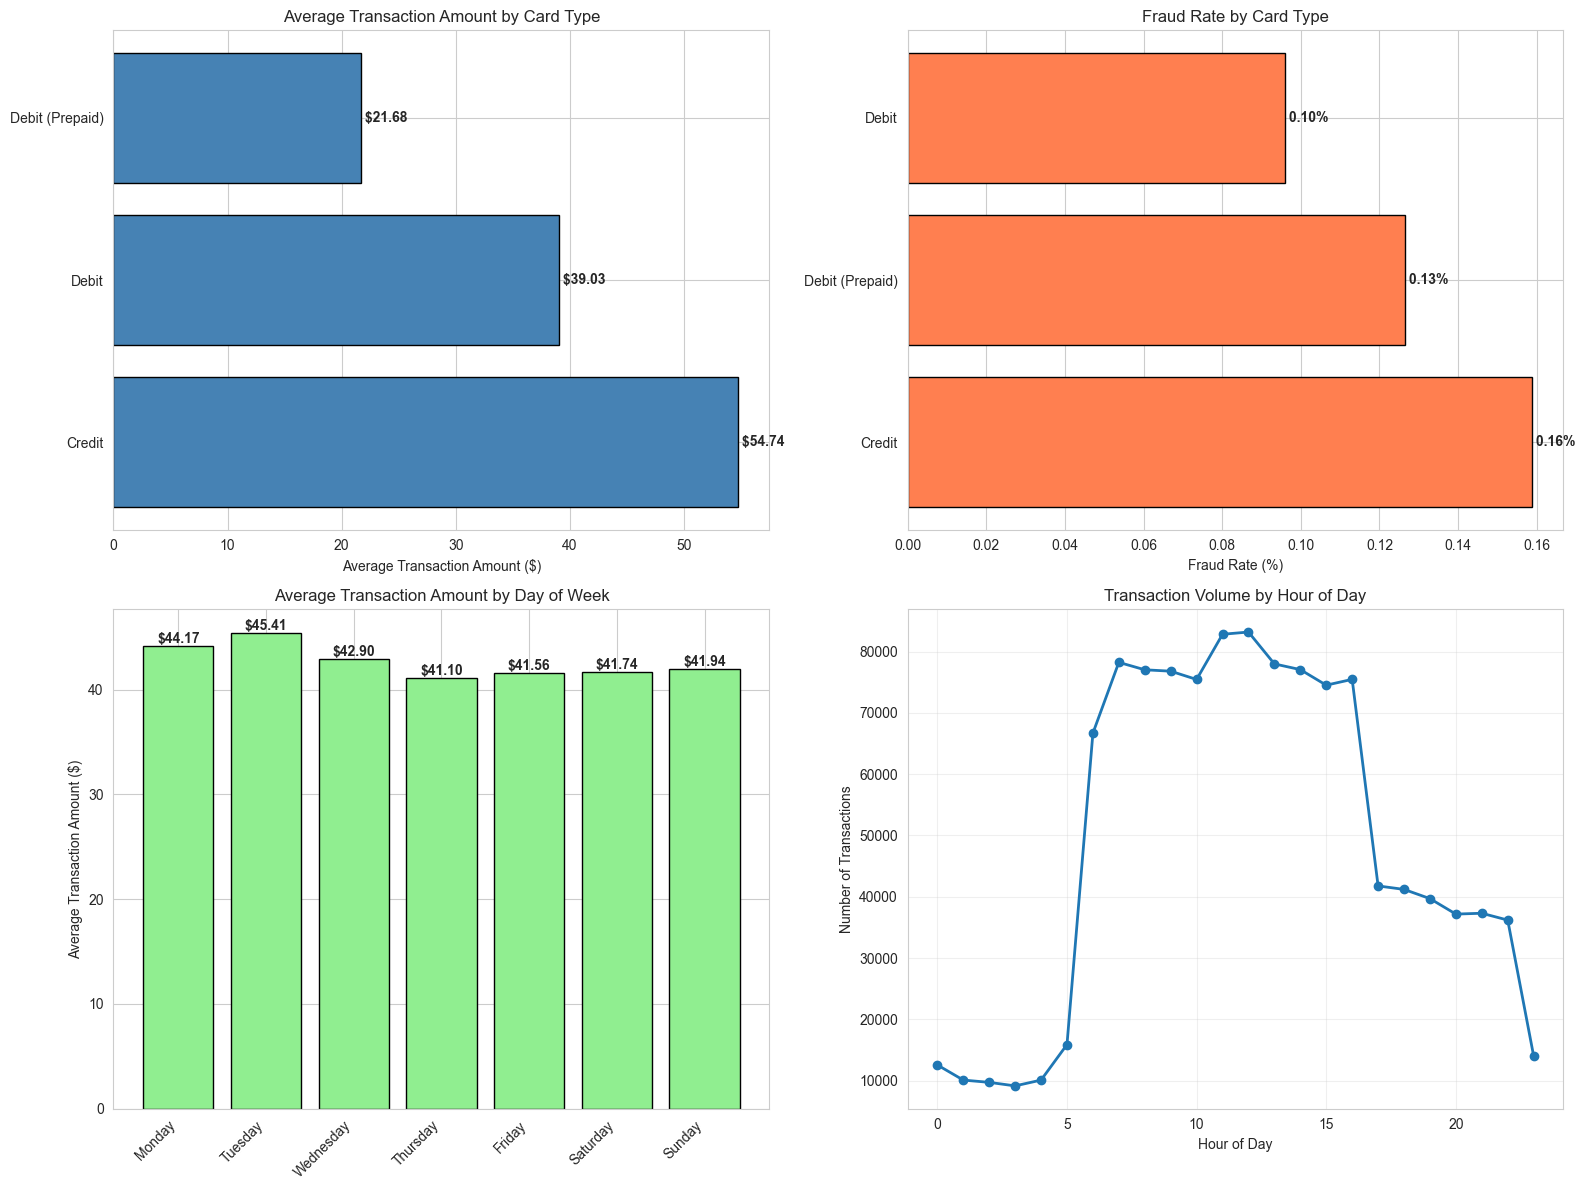

In [37]:
# Visualize grouped summaries
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Average transaction amount by card type
avg_by_card = df_merged.groupby('card_type')['amount_clean'].mean().sort_values(ascending=False)
axes[0, 0].barh(avg_by_card.index, avg_by_card.values, color='steelblue', edgecolor='black')
axes[0, 0].set_xlabel('Average Transaction Amount ($)')
axes[0, 0].set_title('Average Transaction Amount by Card Type')
for i, v in enumerate(avg_by_card.values):
    axes[0, 0].text(v, i, f' ${v:.2f}', va='center', fontweight='bold')

# Fraud rate by card type
fraud_rate_by_card = df_merged.groupby('card_type')['is_fraud'].mean().sort_values(ascending=False) * 100
axes[0, 1].barh(fraud_rate_by_card.index, fraud_rate_by_card.values, color='coral', edgecolor='black')
axes[0, 1].set_xlabel('Fraud Rate (%)')
axes[0, 1].set_title('Fraud Rate by Card Type')
for i, v in enumerate(fraud_rate_by_card.values):
    axes[0, 1].text(v, i, f' {v:.2f}%', va='center', fontweight='bold')

# Average transaction amount by day of week
day_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
avg_by_day = df_merged.groupby('day_of_week')['amount_clean'].mean().reindex(day_order)
axes[1, 0].bar(range(len(avg_by_day)), avg_by_day.values, color='lightgreen', edgecolor='black')
axes[1, 0].set_xticks(range(len(avg_by_day)))
axes[1, 0].set_xticklabels(avg_by_day.index, rotation=45, ha='right')
axes[1, 0].set_ylabel('Average Transaction Amount ($)')
axes[1, 0].set_title('Average Transaction Amount by Day of Week')
for i, v in enumerate(avg_by_day.values):
    axes[1, 0].text(i, v, f'${v:.2f}', ha='center', va='bottom', fontweight='bold')

# Transactions by hour
trans_by_hour = df_merged.groupby('hour').size()
axes[1, 1].plot(trans_by_hour.index, trans_by_hour.values, marker='o', linewidth=2, markersize=6)
axes[1, 1].set_xlabel('Hour of Day')
axes[1, 1].set_ylabel('Number of Transactions')
axes[1, 1].set_title('Transaction Volume by Hour of Day')
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


## 4. Insights

Based on the exploratory data analysis, here are the key patterns and anomalies identified:


### Insight 1: Imbalanced Fraud Distribution

The dataset shows a significant class imbalance in fraud detection. Only a small percentage of transactions are labeled as fraudulent, which is typical for real-world fraud detection scenarios. This imbalance will require special attention during modeling, such as using techniques like SMOTE, class weighting, or stratified sampling to ensure the model can effectively learn to identify fraudulent transactions.

**Implications:**
- Standard accuracy metrics may be misleading; precision, recall, and F1-score will be more appropriate
- The model may have a bias toward predicting non-fraudulent transactions
- Cost-sensitive learning approaches may be necessary to minimize false negatives (missed fraud)


### Insight 2: Card Type and Fraud Risk Correlation

Different card types show varying fraud rates. Credit cards and certain debit card types may exhibit different fraud patterns. This suggests that card type is a significant predictor of fraud risk and should be carefully considered in the modeling process.

**Implications:**
- Card type should be a key feature in fraud prediction models
- Different fraud detection strategies may be needed for different card types
- Business rules or separate models for different card types could improve performance


### Insight 3: Temporal Patterns in Transactions

The analysis reveals distinct temporal patterns in transaction behavior, including variations by day of week and hour of day. These patterns could indicate normal vs. anomalous behavior, as fraudulent transactions may occur at unusual times or follow different temporal distributions compared to legitimate transactions.

**Implications:**
- Time-based features (hour, day of week, month) are important for fraud detection
- Anomalies in transaction timing could be strong indicators of fraud
- Real-time fraud detection systems should incorporate temporal context


In [38]:
# Additional analysis to support insights
print("ADDITIONAL ANALYSIS FOR INSIGHTS")
print("=" * 60)

# Insight 1: Fraud distribution details
print("\nInsight 1 - Fraud Distribution:")
print(f"Total transactions: {len(transactions_with_fraud):,}")
print(f"Transactions with fraud labels: {transactions_with_fraud['is_fraud'].notna().sum():,}")
print(f"Fraud transactions: {transactions_with_fraud['is_fraud'].sum():,}")
print(f"Non-fraud transactions: {(transactions_with_fraud['is_fraud']==0).sum():,}")
if transactions_with_fraud['is_fraud'].notna().sum() > 0:
    print(f"Fraud rate: {(transactions_with_fraud['is_fraud'].sum() / transactions_with_fraud['is_fraud'].notna().sum() * 100):.2f}%")

# Insight 2: Fraud by card type
print("\n" + "=" * 60)
print("\nInsight 2 - Fraud Rate by Card Type:")
fraud_card_analysis = df_merged.groupby('card_type')['is_fraud'].agg(['sum', 'count', 'mean']).sort_values('mean', ascending=False)
fraud_card_analysis.columns = ['Fraud_Count', 'Total_Count', 'Fraud_Rate']
fraud_card_analysis['Fraud_Rate_Pct'] = fraud_card_analysis['Fraud_Rate'] * 100
print(fraud_card_analysis)

# Insight 3: Temporal patterns
print("\n" + "=" * 60)
print("\nInsight 3 - Transaction Patterns by Hour:")
hourly_patterns = df_merged.groupby('hour').agg({
    'amount_clean': ['mean', 'count'],
    'is_fraud': 'count'
}).round(2)
print(hourly_patterns.head(10))

print("\nTransaction Patterns by Day of Week:")
daily_patterns = df_merged.groupby('day_of_week').agg({
    'amount_clean': ['mean', 'count'],
    'is_fraud': 'mean'
}).round(2)
print(daily_patterns)


ADDITIONAL ANALYSIS FOR INSIGHTS

Insight 1 - Fraud Distribution:
Total transactions: 1,159,966
Transactions with fraud labels: 1,159,966
Fraud transactions: 1,360
Non-fraud transactions: 1,158,606
Fraud rate: 0.12%


Insight 2 - Fraud Rate by Card Type:
                 Fraud_Count  Total_Count  Fraud_Rate  Fraud_Rate_Pct
card_type                                                            
Credit                   562       353825    0.001588        0.158836
Debit (Prepaid)           99        78240    0.001265        0.126534
Debit                    699       727901    0.000960        0.096030


Insight 3 - Transaction Patterns by Hour:
     amount_clean        is_fraud
             mean  count    count
hour                             
0           48.07  12552    12552
1           58.47  10086    10086
2           48.78   9713     9713
3           54.16   9136     9136
4           53.68  10084    10084
5           45.37  15875    15875
6           33.98  66682    66682
7          

# Part 2: Data Preprocessing

## Objective
### Prepare the data for further analysis and modeling


### 1.1 Data Integration

Identifying Relevant features

In [39]:
# Based on correlation matrix, three features had a low positive correlation 
# with is_fraud, since the data is imbalanced, 
# we will test to see if they are really relevant

# num of cred cards
print("=" * 80)
print("num_credit_cards vs fraud relationship")
print("=" * 80)

# 1. Fraud rate by number of credit cards
print("\n1. Fraud Rate by Number of Credit Cards:")
print("-" * 80)
fraud_by_num_cards = df_merged.groupby('num_credit_cards')['is_fraud'].agg([
    ('Total_Transactions', 'count'),
    ('Fraud_Count', 'sum'),
    ('Fraud_Rate', 'mean')
]).sort_index()
print(fraud_by_num_cards)

num_credit_cards vs fraud relationship

1. Fraud Rate by Number of Credit Cards:
--------------------------------------------------------------------------------
                  Total_Transactions  Fraud_Count  Fraud_Rate
num_credit_cards                                             
1                              77543           67    0.000864
2                             147780          121    0.000819
3                             272860          339    0.001242
4                             305219          316    0.001035
5                             192366          213    0.001107
6                             102545          195    0.001902
7                              41565           67    0.001612
8                              17518           35    0.001998
9                               2570            7    0.002724


Generally, the more credit cards people own, the higher the total number of fraud incidents. However, there is a dip in reported fraud counts for individuals owning 6 to 9 credit cards. This decrease is not due to better security, but because fewer people own that many cards, leading to a smaller total volume of transactions from this group. If we look at the rate of fraud, comparing someone with seven credit cards to someone with only one, the person with seven cards has an equivalent amount of fraud despite having a lower total volume of transactions than the one-card group. This suggests that the likelihood or severity of fraud per cardholder increases with the number of cards owned.

In [40]:
print("=" * 80)
print("current_age vs fraud relationship")
print("=" * 80)

# Create age bins for better visualization
df_merged['age_bin'] = pd.cut(df_merged['current_age'], 
                               bins=[0, 25, 35, 45, 55, 65, 75, 150], 
                               labels=['18-25', '26-35', '36-45', '46-55', '56-65', '66-75', '76+'])

# 1. Fraud rate by age bins
print("\n1. Fraud Rate by Age Group:")
print("-" * 80)
fraud_by_age = df_merged.groupby('age_bin')['is_fraud'].agg([
    ('Total_Transactions', 'count'),
    ('Fraud_Count', 'sum'),
    ('Fraud_Rate', 'mean')
])
print(fraud_by_age)

current_age vs fraud relationship

1. Fraud Rate by Age Group:
--------------------------------------------------------------------------------
         Total_Transactions  Fraud_Count  Fraud_Rate
age_bin                                             
18-25                  8179            8    0.000978
26-35                130039          124    0.000954
36-45                242882          219    0.000902
46-55                305898          325    0.001062
56-65                216792          265    0.001222
66-75                115471          188    0.001628
76+                  140705          231    0.001642


The analysis clearly establishes a significant age-related disparity in financial fraud risk, indicating that older age groups experience a disproportionately higher fraud rate even when their overall transactional activity is lower. While the highest gross count of fraud naturally correlates with cohorts that have the largest volume of transactions, the inherent vulnerability of older populations is starkly revealed through a rate comparison. Specifically, the 66–75 age group recorded 188 instances of fraud across only 115,000 transactions. This rate is dramatically higher than that of the 26–35 age group, which recorded a lesser 124 fraud incidents despite having a higher total volume of 130,000 transactions. This empirical evidence underscores that the per-transaction probability of experiencing fraud escalates markedly with age, as the older cohort incurred over 50% more fraud cases on a smaller transactional base.

In [41]:
print("=" * 80)
print("amount_clean vs fraud relationship")
print("=" * 80)

# Create amount bins for better visualization
df_merged['amount_bin'] = pd.cut(df_merged['amount_clean'], 
                                  bins=[0, 20, 40, 60, 100, 200, 10000], 
                                  labels=['$0-20', '$20-40', '$40-60', '$60-100', '$100-200', '$200+'])

# 1. Fraud rate by transaction amount bins
print("\n1. Fraud Rate by Transaction Amount:")
print("-" * 80)
fraud_by_amount = df_merged.groupby('amount_bin')['is_fraud'].agg([
    ('Total_Transactions', 'count'),
    ('Fraud_Count', 'sum'),
    ('Fraud_Rate', 'mean')
])
print(fraud_by_amount)

amount_clean vs fraud relationship

1. Fraud Rate by Transaction Amount:
--------------------------------------------------------------------------------
            Total_Transactions  Fraud_Count  Fraud_Rate
amount_bin                                             
$0-20                   422399          491    0.001162
$20-40                  213517          181    0.000848
$40-60                  158142          127    0.000803
$60-100                 185115          187    0.001010
$100-200                 95731          181    0.001891
$200+                    27308          161    0.005896


The relationship between transaction amount and fraud risk is complex, but the data clearly indicates that higher-value transactions carry a disproportionately greater inherent risk. While the $0-20 transaction bracket reports the highest absolute number of fraud incidents, this is merely a result of the extraordinarily high volume of transactions within that low-value range. When the risk is normalized by volume, it becomes evident that the fraud rate increases sharply with transaction value. This trend is clearly illustrated by comparing the $20-40 bin, which handled approximately 200,000 transactions and resulted in 181 fraud counts, against the $100-200 bin, which recorded the exact same number of fraud counts (181) despite having a substantially lower volume of transactions—around 95,000. This finding demonstrates that the likelihood of fraud is more than double in the $100-200 range compared to the $20-40 range, underscoring that the true financial risk is concentrated in the higher-value transaction brackets.

Other features were also selected after assessing them with fraud rate:

In [42]:
# other relevant features: hour, use chip, card type, 
# credit score, day_of_week, mcc, merchant city, merchant state,
# credit limit

# Calculate fraud rate by hour with proper precision
fraud_by_hour = df_merged.groupby('hour')['is_fraud'].agg([
    ('Total_Transactions', 'count'),
    ('Fraud_Count', 'sum'),
    ('Fraud_Rate', 'mean')
])

print("\nFraud Rate by Hour of Day:")
print("-" * 80)
print(fraud_by_hour)


Fraud Rate by Hour of Day:
--------------------------------------------------------------------------------
      Total_Transactions  Fraud_Count  Fraud_Rate
hour                                             
0                  12552            0    0.000000
1                  10086            0    0.000000
2                   9713            0    0.000000
3                   9136            0    0.000000
4                  10084            2    0.000198
5                  15875            0    0.000000
6                  66682            1    0.000015
7                  78238            1    0.000013
8                  77025            1    0.000013
9                  76797            1    0.000013
10                 75446           81    0.001074
11                 82819          156    0.001884
12                 83184          135    0.001623
13                 77985          147    0.001885
14                 77054          153    0.001986
15                 74515          135    

Based on the results above, we can see that there are specific hours where most fraud transactions occur, making it a significant predictor. 

In [43]:
# Fraud Analysis: use_chip (Transaction Type)
print("=" * 80)
print("use_chip vs fraud relationship")
print("=" * 80)

fraud_by_chip = df_merged.groupby('use_chip')['is_fraud'].agg([
    ('Total_Transactions', 'count'),
    ('Fraud_Count', 'sum'),
    ('Fraud_Rate', 'mean')
])

print("\nFraud Rate by Transaction Type:")
print("-" * 80)
print(fraud_by_chip)

use_chip vs fraud relationship

Fraud Rate by Transaction Type:
--------------------------------------------------------------------------------
                    Total_Transactions  Fraud_Count  Fraud_Rate
use_chip                                                       
Chip Transaction                823180         1238    0.001504
Online Transaction              139987            0    0.000000
Swipe Transaction               196799          122    0.000620


Most fraud transactions occur when its a chip transaction.

In [44]:
# Fraud Analysis: card_type
print("=" * 80)
print("card_type vs fraud relationship")
print("=" * 80)

fraud_by_card_type = df_merged.groupby('card_type')['is_fraud'].agg([
    ('Total_Transactions', 'count'),
    ('Fraud_Count', 'sum'),
    ('Fraud_Rate', 'mean')
])

print("\nFraud Rate by Card Type:")
print("-" * 80)
print(fraud_by_card_type)

card_type vs fraud relationship

Fraud Rate by Card Type:
--------------------------------------------------------------------------------
                 Total_Transactions  Fraud_Count  Fraud_Rate
card_type                                                   
Credit                       353825          562    0.001588
Debit                        727901          699    0.000960
Debit (Prepaid)               78240           99    0.001265


Most fraud transactions occur when the card type is credit. 

In [45]:
print("=" * 80)
print("credit_score vs fraud relationship")
print("=" * 80)

# Create credit score bins
df_merged['credit_score_bin'] = pd.cut(df_merged['credit_score'], 
                                        bins=[0, 580, 670, 740, 800, 900],
                                        labels=['Poor (≤580)', 'Fair (581-670)', 'Good (671-740)', 
                                               'Very Good (741-800)', 'Excellent (800+)'])

fraud_by_credit = df_merged.groupby('credit_score_bin')['is_fraud'].agg([
    ('Total_Transactions', 'count'),
    ('Fraud_Count', 'sum'),
    ('Fraud_Rate', 'mean')
])

print("\nFraud Rate by Credit Score Range:")
print("-" * 80)
print(fraud_by_credit)

credit_score vs fraud relationship

Fraud Rate by Credit Score Range:
--------------------------------------------------------------------------------
                     Total_Transactions  Fraud_Count  Fraud_Rate
credit_score_bin                                                
Poor (≤580)                       42446           51    0.001202
Fair (581-670)                   169665          173    0.001020
Good (671-740)                   552008          648    0.001174
Very Good (741-800)              297617          358    0.001203
Excellent (800+)                  98230          130    0.001323


As credit score increasees, fraud rate increases. 

In [46]:
print("=" * 80)
print("day_of_week vs fraud relationship")
print("=" * 80)

fraud_by_day = df_merged.groupby('day_of_week')['is_fraud'].agg([
    ('Total_Transactions', 'count'),
    ('Fraud_Count', 'sum'),
    ('Fraud_Rate', 'mean')
])

# Reorder by day of week
fraud_by_day = fraud_by_day.reindex(day_order)

print("\nFraud Rate by Day of Week:")
print("-" * 80)
print(fraud_by_day)

day_of_week vs fraud relationship

Fraud Rate by Day of Week:
--------------------------------------------------------------------------------
             Total_Transactions  Fraud_Count  Fraud_Rate
day_of_week                                             
Monday                   170146            4    0.000024
Tuesday                  155214          339    0.002184
Wednesday                156622            7    0.000045
Thursday                 172478          330    0.001913
Friday                   168866          338    0.002002
Saturday                 168571          339    0.002011
Sunday                   168069            3    0.000018


Some days: tuesday, thursday, friday and saturday, is where most fraud transactions occur. 

In [47]:
# Fraud Analysis: credit_limit (binned)
print("=" * 50)
print("credit_limit vs fraud relationship")
print("=" * 50)

# Create credit limit bins
df_merged['credit_limit_bin'] = pd.cut(df_merged['credit_limit_clean'], 
                                        bins=[0, 5000, 10000, 15000, 25000, 200000],
                                        labels=['$0-5K', '$5K-10K', '$10K-15K', '$15K-25K', '$25K+'])

fraud_by_limit = df_merged.groupby('credit_limit_bin')['is_fraud'].agg([
    ('Total_Transactions', 'count'),
    ('Fraud_Count', 'sum'),
    ('Fraud_Rate', 'mean')
])

print("\nFraud Rate by Credit Limit Range:")
print("-" * 50)
print(fraud_by_limit)

credit_limit vs fraud relationship

Fraud Rate by Credit Limit Range:
--------------------------------------------------
                  Total_Transactions  Fraud_Count  Fraud_Rate
credit_limit_bin                                             
$0-5K                         173421          212    0.001222
$5K-10K                       210838          326    0.001546
$10K-15K                      259190          290    0.001119
$15K-25K                      319554          340    0.001064
$25K+                         191842          187    0.000975


The lower the credit limit is, the more risky the customer. But that depends on the user age and other factors, but usually the lower it is the more risky. 

In [48]:
# Fraud Analysis: MCC (Merchant Category Code)
print("=" * 80)
print("MCC (Merchant Category Code) vs fraud relationship")
print("=" * 80)

# Analyze fraud by top 15 MCCs (by transaction volume)
top_15_mccs = df_merged['mcc'].value_counts().head(15).index

fraud_by_mcc = df_merged[df_merged['mcc'].isin(top_15_mccs)].groupby('mcc')['is_fraud'].agg([
    ('Total_Transactions', 'count'),
    ('Fraud_Count', 'sum'),
    ('Fraud_Rate', 'mean')
])

print("\nFraud Rate by Top 15 Merchant Categories (sorted by fraud rate):")
print("-" * 80)
# Sort by fraud rate descending
fraud_by_mcc_sorted = fraud_by_mcc.sort_values('Fraud_Rate', ascending=False)
print(fraud_by_mcc_sorted)


MCC (Merchant Category Code) vs fraud relationship



Fraud Rate by Top 15 Merchant Categories (sorted by fraud rate):
--------------------------------------------------------------------------------
      Total_Transactions  Fraud_Count  Fraud_Rate
mcc                                              
5311               41227          290    0.007034
5310               21510          101    0.004695
5813               21520           24    0.001115
4121               45692           50    0.001094
5411              138936          130    0.000936
5912               66815           55    0.000823
5541              123098           78    0.000634
5814               43544           20    0.000459
5812               86916           32    0.000368
5499              126635           45    0.000355
4829               50436            0    0.000000
4900               21257            0    0.000000
5300               51904            0    0.000000
4784               61755            0    0.000000
7538               42062            0    0.000000


MCC (type of business) have specific ones with very high fraud rates. 

In [49]:
# Merging the relevant features into a dataframe 
selected_columns = [
    'num_credit_cards',
    'current_age',       
    'amount_clean',       
    'hour',
    'use_chip',
    'card_type',
    'merchant_city', 
    'merchant_state',         
    'credit_score', 
    'day_of_week',
    'mcc',
    'credit_limit_clean', 
    'is_fraud'
]

# Create the initial DataFrame with selected columns
rel_merged = df_merged[selected_columns].copy()


In [50]:
# FIX INTEGRATION ERRORS IN rel_merged
rel_merged_clean = rel_merged.copy()

# ISSUE 1: Remove duplicate rows
print("\n1. DUPLICATE ROWS")
print("-" * 80)
print(f"Before: {len(rel_merged_clean)} rows")
rel_merged_clean = rel_merged_clean.drop_duplicates()
print(f"After: {len(rel_merged_clean)} rows")
print(f"Removed: {len(rel_merged) - len(rel_merged_clean)} duplicate rows ✓")

# ISSUE 2: Handle negative amounts (likely refunds or data errors)
print("\n2. NEGATIVE AMOUNTS")
print("-" * 80)
negative_count = (rel_merged_clean['amount_clean'] < 0).sum()
print(negative_count)
# Keep negative amounts as they could represent refunds - these are valid transactions

# ISSUE 3: Standardize categorical columns (already consistent, just verify)
print("\n3. STANDARDIZING CATEGORICAL COLUMNS")

# Verify use_chip values
print(f"use_chip categories: {sorted(rel_merged_clean['use_chip'].unique())}")
print("  No standardization needed ")

# Verify card_type values
print(f"card_type categories: {sorted(rel_merged_clean['card_type'].unique())}")
print("  No standardization needed ")

# Verify day_of_week (order matters for analysis)
day_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
rel_merged_clean['day_of_week'] = pd.Categorical(
    rel_merged_clean['day_of_week'], 
    categories=day_order, 
    ordered=True
)
print("day_of_week ordered categorically")

# ISSUE 4: Verify numerical constraints
print("\n4. VALIDATING NUMERICAL COLUMN RANGES")

# num_credit_cards should be positive
assert (rel_merged_clean['num_credit_cards'] > 0).all(), "Found non-positive credit card counts"
print("num_credit_cards are all positive")

# current_age should be reasonable (18-120)
age_outliers = ((rel_merged_clean['current_age'] < 18) | (rel_merged_clean['current_age'] > 120)).sum()
print(f"  current_age range: {rel_merged_clean['current_age'].min()} - {rel_merged_clean['current_age'].max()}")
if age_outliers > 0:
    print(f"  WARNING: {age_outliers} age values outside 18-120 range")
else:
    print("all ages within reasonable range (18-120)")

# hour should be 0-23
assert (rel_merged_clean['hour'] >= 0).all() and (rel_merged_clean['hour'] <= 23).all()
print(" hour is within valid range (0-23)")

# credit_score should be 0-850
assert (rel_merged_clean['credit_score'] >= 0).all() and (rel_merged_clean['credit_score'] <= 850).all()
print("credit scores within valid range (0-850)")

# credit_limit_clean should be non-negative
assert (rel_merged_clean['credit_limit_clean'] >= 0).all()
print(" credit limit all non-negative")

# is_fraud should be 0 or 1
assert set(rel_merged_clean['is_fraud'].unique()).issubset({0, 1})
print("is_fraud all binary (0 or 1)")


# Update rel_merged with the cleaned version
rel_merged = rel_merged_clean




1. DUPLICATE ROWS
--------------------------------------------------------------------------------
Before: 1159966 rows
After: 1131875 rows
Removed: 28091 duplicate rows ✓

2. NEGATIVE AMOUNTS
--------------------------------------------------------------------------------
55528

3. STANDARDIZING CATEGORICAL COLUMNS
use_chip categories: ['Chip Transaction', 'Online Transaction', 'Swipe Transaction']
  No standardization needed 
card_type categories: ['Credit', 'Debit', 'Debit (Prepaid)']
  No standardization needed 
day_of_week ordered categorically

4. VALIDATING NUMERICAL COLUMN RANGES
num_credit_cards are all positive
  current_age range: 23 - 101
all ages within reasonable range (18-120)
 hour is within valid range (0-23)
credit scores within valid range (0-850)
 credit limit all non-negative
is_fraud all binary (0 or 1)


### Missing values

In [51]:
# Check for missing values in rel_merged
print("Missing Values Analysis")
print("=" * 60)

# Total missing values
total_missing = rel_merged.isnull().sum().sum()
print(f"Total missing values: {total_missing}")
print()

# Missing values per column
print("Missing values per column:")
print("-" * 60)
missing_summary = pd.DataFrame({
    'Column': rel_merged.columns,
    'Missing_Count': rel_merged.isnull().sum().values,
    'Missing_Rate': (rel_merged.isnull().sum().values / len(rel_merged) * 100).round(2)
})
print(missing_summary.to_string(index=False))
print()

Missing Values Analysis
Total missing values: 140691

Missing values per column:
------------------------------------------------------------
            Column  Missing_Count  Missing_Rate
  num_credit_cards              0          0.00
       current_age              0          0.00
      amount_clean              0          0.00
              hour              0          0.00
          use_chip              0          0.00
         card_type              0          0.00
     merchant_city              0          0.00
    merchant_state         140691         12.43
      credit_score              0          0.00
       day_of_week              0          0.00
               mcc              0          0.00
credit_limit_clean              0          0.00
          is_fraud              0          0.00



In [52]:
# Fill missing values
rel_merged['merchant_state'] = rel_merged['merchant_state'].fillna('Unknown')

# Then target encode like you did with merchant_city
state_fraud_rate = rel_merged.groupby('merchant_state')['is_fraud'].mean().to_dict()
state_frequency = rel_merged['merchant_state'].value_counts(normalize=True).to_dict()

rel_merged['merchant_state_fraud_rate'] = rel_merged['merchant_state'].map(state_fraud_rate)

rel_merged = rel_merged.drop(['merchant_state'], axis=1)

### Outlier detection and treatment

In [53]:
# Define numerical columns for outlier detection
numerical_cols = ['num_credit_cards', 'current_age', 'amount_clean', 
                  'credit_score', 'credit_limit_clean']


outlier_summary = []

for col in numerical_cols:
    Q1 = rel_merged[col].quantile(0.25)
    Q3 = rel_merged[col].quantile(0.75)
    IQR = Q3 - Q1
    
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    
    outliers = rel_merged[(rel_merged[col] < lower_bound) | (rel_merged[col] > upper_bound)]
    outlier_count = len(outliers)
    outlier_percent = (outlier_count / len(rel_merged)) * 100
    
    outlier_summary.append({
        'Column': col,
        'Outlier_Count': outlier_count,
        'Outlier_Percent': round(outlier_percent, 2)
    })
    
outlier_df = pd.DataFrame(outlier_summary)
print(outlier_df.to_string(index=False))


            Column  Outlier_Count  Outlier_Percent
  num_credit_cards           2559             0.23
       current_age           7686             0.68
      amount_clean          95648             8.45
      credit_score          35132             3.10
credit_limit_clean          40962             3.62


In [54]:
# INVESTIGATING AMOUNT OUTLIERS (NEGATIVE)
print("=" * 60)
print("INVESTIGATING AMOUNT OUTLIERS - NEGATIVE & POSITIVE")
print("=" * 60)

# Define outliers using IQR
Q1 = rel_merged['amount_clean'].quantile(0.25)
Q3 = rel_merged['amount_clean'].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

print(f"\nIQR Boundaries:")
print(f"Lower bound: ${lower_bound:.2f}")
print(f"Upper bound: ${upper_bound:.2f}")

print("\n" + "=" * 60)
print("NEGATIVE OUTLIERS")
print("=" * 60)

negative_mask = rel_merged['amount_clean'] < 0
negative_outliers = rel_merged[negative_mask & (rel_merged['amount_clean'] < lower_bound)]

# Fraud rate for negative amounts
negative_amounts = rel_merged[negative_mask]
fraud_rate_negative = negative_amounts['is_fraud'].mean() * 100

print(f"\nFRAUD RATE IN NEGATIVE AMOUNTS")
print("-" * 60)
print(f"Fraud rate in ALL negative amounts: {fraud_rate_negative:.2f}%")
print(f"Fraud rate in negative OUTLIERS: {negative_outliers['is_fraud'].mean()*100:.2f}%")

# Check other features
print(f"\nTRANSACTION METHOD FOR NEGATIVE AMOUNTS")
print("-" * 60)
print(negative_amounts['use_chip'].value_counts())

print(f"\nCARD TYPE FOR NEGATIVE AMOUNTS")
print("-" * 60)
print(negative_amounts['card_type'].value_counts())

print("Negative amounts do not indicate fraud, and when checking the outlier with other features it doesnt seem to have an impact, all looks normal")


INVESTIGATING AMOUNT OUTLIERS - NEGATIVE & POSITIVE

IQR Boundaries:
Lower bound: $-70.67
Upper bound: $141.19

NEGATIVE OUTLIERS

FRAUD RATE IN NEGATIVE AMOUNTS
------------------------------------------------------------
Fraud rate in ALL negative amounts: 0.05%
Fraud rate in negative OUTLIERS: 0.07%

TRANSACTION METHOD FOR NEGATIVE AMOUNTS
------------------------------------------------------------
use_chip
Chip Transaction      44478
Swipe Transaction     10767
Online Transaction      283
Name: count, dtype: int64

CARD TYPE FOR NEGATIVE AMOUNTS
------------------------------------------------------------
card_type
Debit              34732
Credit             18013
Debit (Prepaid)     2783
Name: count, dtype: int64
Negative amounts do not indicate fraud, and when checking the outlier with other features it doesnt seem to have an impact, all looks normal


In [55]:
# INVESTIGATING AMOUNT OUTLIERS (POSITIVE)
print( "=" * 60)
print("PART 2: POSITIVE OUTLIERS (HIGH AMOUNTS)")
print("=" * 60)

positive_outliers = rel_merged[rel_merged['amount_clean'] > upper_bound]
positive_count = len(positive_outliers)
positive_percent = (positive_count / len(rel_merged)) * 100

# Fraud rate for positive outliers
normal_amounts = rel_merged[(rel_merged['amount_clean'] >= lower_bound) & 
                            (rel_merged['amount_clean'] <= upper_bound)]
fraud_rate_positive_outliers = positive_outliers['is_fraud'].mean() * 100
fraud_rate_normal = normal_amounts['is_fraud'].mean() * 100

print(f"\nFRAUD RATE IN POSITIVE OUTLIERS")
print("-" * 60)
print(f"Fraud rate in HIGH amount outliers: {fraud_rate_positive_outliers:.2f}%")
print(f"Fraud rate in NORMAL amounts: {fraud_rate_normal:.2f}%")

print(f"\nTRANSACTION METHOD FOR HIGH AMOUNTS")
print("-" * 60)
print(positive_outliers['use_chip'].value_counts())

print(f"\nCARD TYPES FOR HIGH AMOUNTS")
print("-" * 60)
print(positive_outliers['card_type'].value_counts())

print("outliers above the max could possibly indicate fraud.")

PART 2: POSITIVE OUTLIERS (HIGH AMOUNTS)

FRAUD RATE IN POSITIVE OUTLIERS
------------------------------------------------------------
Fraud rate in HIGH amount outliers: 0.40%
Fraud rate in NORMAL amounts: 0.11%

TRANSACTION METHOD FOR HIGH AMOUNTS
------------------------------------------------------------
use_chip
Chip Transaction      38308
Online Transaction    11704
Swipe Transaction     10000
Name: count, dtype: int64

CARD TYPES FOR HIGH AMOUNTS
------------------------------------------------------------
card_type
Debit              29978
Credit             29964
Debit (Prepaid)       70
Name: count, dtype: int64
outliers above the max could possibly indicate fraud.


In [56]:
# INVESTIGATING CREDIT_LIMIT OUTLIERS
print("=" * 60)
print("INVESTIGATING CREDIT_LIMIT_CLEAN OUTLIERS")
print("=" * 60)

# Get outliers above upper bound
high_limit_outliers = rel_merged[rel_merged['credit_limit_clean'] > upper_bound]
normal_limits = rel_merged[(rel_merged['credit_limit_clean'] >= lower_bound) & 
                           (rel_merged['credit_limit_clean'] <= upper_bound)]

print(f"\nTotal high limit outliers: {len(high_limit_outliers):,} ({len(high_limit_outliers)/len(rel_merged)*100:.2f}%)")
print(f"Range: ${high_limit_outliers['credit_limit_clean'].min():.2f} to ${high_limit_outliers['credit_limit_clean'].max():.2f}")

# Fraud rate for high limit outliers
fraud_rate_outliers = high_limit_outliers['is_fraud'].mean() * 100
fraud_rate_normal = normal_limits['is_fraud'].mean() * 100

print(f"\nFRAUD RATE IN HIGH CREDIT LIMIT")
print("-" * 60)
print(f"Fraud rate in HIGH limit outliers: {fraud_rate_outliers:.2f}%")
print(f"Fraud rate in NORMAL limits: {fraud_rate_normal:.2f}%")

# Check other features
print(f"\nTRANSACTION METHOD FOR HIGH LIMITS")
print("-" * 60)
print(high_limit_outliers['use_chip'].value_counts())

print(f"\nMERCHANT CATEGORIES (MCC) FOR HIGH LIMITS")
print("-" * 60)
print("Top 10:")
print(high_limit_outliers['mcc'].value_counts().head(10))

print(f"\nTRANSACTION AMOUNTS FOR HIGH LIMIT USERS")
print("-" * 60)
print(f"Average transaction (high limits): ${high_limit_outliers['amount_clean'].mean():.2f}")
print(f"Average transaction (normal limits): ${normal_limits['amount_clean'].mean():.2f}")

print("\nHigh credit limit outliers do not indicate fraud, and when checking the outlier with other features it doesnt seem to have an impact, all looks normal")

INVESTIGATING CREDIT_LIMIT_CLEAN OUTLIERS

Total high limit outliers: 1,048,969 (92.68%)
Range: $145.00 to $141391.00

FRAUD RATE IN HIGH CREDIT LIMIT
------------------------------------------------------------
Fraud rate in HIGH limit outliers: 0.12%
Fraud rate in NORMAL limits: 0.12%

TRANSACTION METHOD FOR HIGH LIMITS
------------------------------------------------------------
use_chip
Chip Transaction      741521
Swipe Transaction     178582
Online Transaction    128866
Name: count, dtype: int64

MERCHANT CATEGORIES (MCC) FOR HIGH LIMITS
------------------------------------------------------------
Top 10:
mcc
5411    126261
5499    113236
5541    112765
5812     79226
5912     61816
4784     56641
5300     48842
4121     39999
5814     39846
7538     39156
Name: count, dtype: int64

TRANSACTION AMOUNTS FOR HIGH LIMIT USERS
------------------------------------------------------------
Average transaction (high limits): $43.61
Average transaction (normal limits): $22.28

High credit

In [57]:
# INVESTIGATING CREDIT_SCORE OUTLIERS
print("=" * 60)
print("INVESTIGATING CREDIT_SCORE OUTLIERS")
print("=" * 60)

# Get outliers (both low and high)
score_outliers = rel_merged[(rel_merged['credit_score'] < lower_bound) | 
                            (rel_merged['credit_score'] > upper_bound)]
normal_scores = rel_merged[(rel_merged['credit_score'] >= lower_bound) & 
                           (rel_merged['credit_score'] <= upper_bound)]

print(f"\nTotal credit score outliers: {len(score_outliers):,} ({len(score_outliers)/len(rel_merged)*100:.2f}%)")
print(f"Range: {score_outliers['credit_score'].min():.0f} to {score_outliers['credit_score'].max():.0f}")

# Fraud rate for score outliers
fraud_rate_outliers = score_outliers['is_fraud'].mean() * 100
fraud_rate_normal = normal_scores['is_fraud'].mean() * 100

print(f"\nFRAUD RATE IN CREDIT SCORE OUTLIERS")
print("-" * 60)
print(f"Fraud rate in credit score OUTLIERS: {fraud_rate_outliers:.2f}%")
print(f"Fraud rate in NORMAL scores: {fraud_rate_normal:.2f}%")

# Check other features
print(f"\nTRANSACTION METHOD FOR SCORE OUTLIERS")
print("-" * 60)
print(score_outliers['use_chip'].value_counts())

print(f"\nCARD TYPE FOR SCORE OUTLIERS")
print("-" * 60)
print(score_outliers['card_type'].value_counts())

print(f"\nMERCHANT CATEGORIES (MCC) FOR SCORE OUTLIERS")
print("-" * 60)
print("Top 10:")
print(score_outliers['mcc'].value_counts().head(10))


INVESTIGATING CREDIT_SCORE OUTLIERS

Total credit score outliers: 1,131,875 (100.00%)
Range: 489 to 850

FRAUD RATE IN CREDIT SCORE OUTLIERS
------------------------------------------------------------
Fraud rate in credit score OUTLIERS: 0.12%
Fraud rate in NORMAL scores: nan%

TRANSACTION METHOD FOR SCORE OUTLIERS
------------------------------------------------------------
use_chip
Chip Transaction      800395
Swipe Transaction     191873
Online Transaction    139607
Name: count, dtype: int64

CARD TYPE FOR SCORE OUTLIERS
------------------------------------------------------------
card_type
Debit              711341
Credit             343272
Debit (Prepaid)     77262
Name: count, dtype: int64

MERCHANT CATEGORIES (MCC) FOR SCORE OUTLIERS
------------------------------------------------------------
Top 10:
mcc
5411    138475
5499    122589
5541    121266
5812     86728
5912     66719
4784     61503
5300     51893
4121     45527
5814     43481
7538     42024
Name: count, dtype: int64

#### Outlier Treatment Strategy: 
Negative amounts are replaced with the minimum positive value. High amounts are capped at the maximum normal value, and we add a flag (outlier_high) to remember which ones were originally high. Credit limit and credit score outliers are also capped at their maximum normal values. Features with less than 1% outliers (like num_credit_cards) are replaced with the mean.

In [58]:
rel_merged_treated = rel_merged.copy()

# Calculate IQR bounds for amount_clean
Q1_amount = rel_merged_treated['amount_clean'].quantile(0.25)
Q3_amount = rel_merged_treated['amount_clean'].quantile(0.75)
IQR_amount = Q3_amount - Q1_amount
lower_bound_amount = Q1_amount - 1.5 * IQR_amount
upper_bound_amount = Q3_amount + 1.5 * IQR_amount

# Create outlier_high flag BEFORE capping (preserve original information)
rel_merged_treated['outlier_high'] = (rel_merged_treated['amount_clean'] > upper_bound_amount).astype(int)

high_outlier_count = rel_merged_treated['outlier_high'].sum()

# AMOUNT_CLEAN 
# negative outliers
negative_outliers_mask = rel_merged_treated['amount_clean'] < lower_bound_amount
negative_outlier_count = negative_outliers_mask.sum()
min_non_outlier = rel_merged_treated[rel_merged_treated['amount_clean'] >= lower_bound_amount]['amount_clean'].min()
rel_merged_treated.loc[negative_outliers_mask, 'amount_clean'] = min_non_outlier

#positive outliers
capped_amount = (rel_merged_treated['amount_clean'] > upper_bound_amount).sum()
rel_merged_treated['amount_clean'] = rel_merged_treated['amount_clean'].clip(upper=upper_bound_amount)

In [59]:
# CREDIT_LIMIT_CLEAN 
Q1_limit = rel_merged_treated['credit_limit_clean'].quantile(0.25)
Q3_limit = rel_merged_treated['credit_limit_clean'].quantile(0.75)
IQR_limit = Q3_limit - Q1_limit
upper_bound_limit = Q3_limit + 1.5 * IQR_limit

capped_limit = (rel_merged_treated['credit_limit_clean'] > upper_bound_limit).sum()
rel_merged_treated['credit_limit_clean'] = rel_merged_treated['credit_limit_clean'].clip(upper=upper_bound_limit)

In [60]:

# CREDIT_SCORE - Outliers 
Q1_score = rel_merged_treated['credit_score'].quantile(0.25)
Q3_score = rel_merged_treated['credit_score'].quantile(0.75)
IQR_score = Q3_score - Q1_score
lower_bound_score = Q1_score - 1.5 * IQR_score
upper_bound_score = Q3_score + 1.5 * IQR_score

capped_score_low = (rel_merged_treated['credit_score'] < lower_bound_score).sum()
capped_score_high = (rel_merged_treated['credit_score'] > upper_bound_score).sum()

rel_merged_treated['credit_score'] = rel_merged_treated['credit_score'].clip(
    lower=lower_bound_score, upper=upper_bound_score
)

In [61]:

# NUM_CREDIT_CARDS - Mean imputation (less than 1% outliers)
Q1_cards = rel_merged_treated['num_credit_cards'].quantile(0.25)
Q3_cards = rel_merged_treated['num_credit_cards'].quantile(0.75)
IQR_cards = Q3_cards - Q1_cards
lower_bound_cards = Q1_cards - 1.5 * IQR_cards
upper_bound_cards = Q3_cards + 1.5 * IQR_cards

outliers_mask = (rel_merged_treated['num_credit_cards'] < lower_bound_cards) | \
                (rel_merged_treated['num_credit_cards'] > upper_bound_cards)
outliers_count = outliers_mask.sum()

mean_cards = rel_merged_treated['num_credit_cards'].mean()
rel_merged_treated.loc[outliers_mask, 'num_credit_cards'] = mean_cards


In [62]:
# CURRENT_AGE - Mean imputation (less than 1% outliers)
Q1_age = rel_merged_treated['current_age'].quantile(0.25)
Q3_age = rel_merged_treated['current_age'].quantile(0.75)
IQR_age = Q3_age - Q1_age
lower_bound_age = Q1_age - 1.5 * IQR_age
upper_bound_age = Q3_age + 1.5 * IQR_age

outliers_mask_age = (rel_merged_treated['current_age'] < lower_bound_age) | \
                    (rel_merged_treated['current_age'] > upper_bound_age)
outliers_count_age = outliers_mask_age.sum()

mean_age = rel_merged_treated['current_age'].mean()
rel_merged_treated.loc[outliers_mask_age, 'current_age'] = mean_age


In [63]:
# STEP 4: VERIFICATION
print("VERIFICATION")
print("-" * 60)

# Check for remaining outliers
print("Remaining outliers after treatment:")
outlier_check = []
for col in ['num_credit_cards', 'current_age', 'amount_clean', 'credit_score', 'credit_limit_clean']:
    Q1 = rel_merged_treated[col].quantile(0.25)
    Q3 = rel_merged_treated[col].quantile(0.75)
    IQR = Q3 - Q1
    outliers = ((rel_merged_treated[col] < Q1 - 1.5*IQR) | 
                (rel_merged_treated[col] > Q3 + 1.5*IQR)).sum()
    outlier_check.append({
        'Feature': col,
        'Remaining_Outliers': outliers,
    })

outlier_df = pd.DataFrame(outlier_check)
print(outlier_df.to_string(index=False))

rel_merged = rel_merged_treated.copy()

VERIFICATION
------------------------------------------------------------
Remaining outliers after treatment:
           Feature  Remaining_Outliers
  num_credit_cards                   0
       current_age                   0
      amount_clean                   0
      credit_score                   0
credit_limit_clean                   0


### Feature engineering

In [64]:
# Create sus_hour feature (1 if hour is between 10-19, 0 otherwise)
rel_merged['sus_hour'] = ((rel_merged['hour'] >= 10) & (rel_merged['hour'] <= 19)).astype(int)

# Has customer used this merchant before?
df_merged['merchant_usage_count'] = df_merged.groupby(['card_number', 'merchant_id'])['merchant_id'].transform('count')
rel_merged['is_repeat_merchant'] = (df_merged.loc[rel_merged.index, 'merchant_usage_count'] > 1).astype(int)



#### Engineered features relevance
1. outlier_high

Relevance: Unusually high transactions deviate from a customers normal spending. Based on our assessments, the rate of fraud is higher in transactions where the amount is high compared to the rate of fraud in normal transactions. Banks can use this flag to trigger alerts or warnings. 

2. sus_hour

Relevance: After assessing fraud patterns for each hour, fraud rates elevate during business hours (10am - 7pm). This indicates that frauds usually exploit busy periods when transactions are usually high, making the fraud ones blend in. This enabled time-aware fraud detection. 

3. is_repeat_merchant

Relevance: Legitimate cardholders have spending habits, usually returning to certain merchants they are familiar with. On the other hand, fraudsters typically attempt to take as much money possible quickly at unfamiliar locations upon obtaining stolen card credentials. This feature flags transactions at merchants the cardholder has not previously bought from, creating a behavioral signature that distinguishes established customer patterns from anomalous one-time purchases.

### Encoding and scaling

In [65]:
# Encode use_chip: 1 if Chip Transaction, 0 otherwise
rel_merged['use_chip_encoded'] = (rel_merged['use_chip'] == 'Chip Transaction').astype(int)

# Drop original columns 
rel_merged = rel_merged.drop(['use_chip'], axis=1)

city_fraud_rate = rel_merged.groupby('merchant_city')['is_fraud'].mean().to_dict()

# Also calculate frequency (how often each city appears)
city_frequency = rel_merged['merchant_city'].value_counts(normalize=True).to_dict()

# Apply target encoding
rel_merged['merchant_city_fraud_rate'] = rel_merged['merchant_city'].map(city_fraud_rate)

# Drop original merchant_city column
rel_merged = rel_merged.drop(['merchant_city'], axis=1)



In [66]:
# Define numerical features to normalize
numerical_features = ['num_credit_cards', 'current_age', 'amount_clean', 
                      'credit_score', 'credit_limit_clean']

# Initialize MinMaxScaler (normalizes to 0-1 range)
normalizer = MinMaxScaler()

# Fit and transform the numerical features
rel_merged[numerical_features] = normalizer.fit_transform(rel_merged[numerical_features])


# Part 3: Predictive Analysis

## Objective
### Reliably predict fraudulent transactions based on other features in the dataset.


In [67]:
# Using libraries for this part
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score


# Dropping columns not needed for training model
cols_to_drop = [
    'is_fraud',  
]

X = rel_merged.drop(columns=cols_to_drop, errors='ignore')
y = rel_merged['is_fraud']

# We convert text columns into binary columns
categorical_cols = X.select_dtypes(include=['object', 'category']).columns
X = pd.get_dummies(X, columns=categorical_cols, drop_first=True)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Logistic Regression requires scaling. 
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print("Data prepared successfully.")
print(f"Training features shape: {X_train_scaled.shape}")
print(f"Fraud cases in Train set: {y_train.sum()}")


Data prepared successfully.
Training features shape: (905500, 21)
Fraud cases in Train set: 1088


Decision Tree

Training Decision Tree...

===== Decision Tree Results =======
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    226103
           1       0.61      0.99      0.75       272

    accuracy                           1.00    226375
   macro avg       0.81      0.99      0.88    226375
weighted avg       1.00      1.00      1.00    226375

AUC-ROC Score: 0.9922689125804456


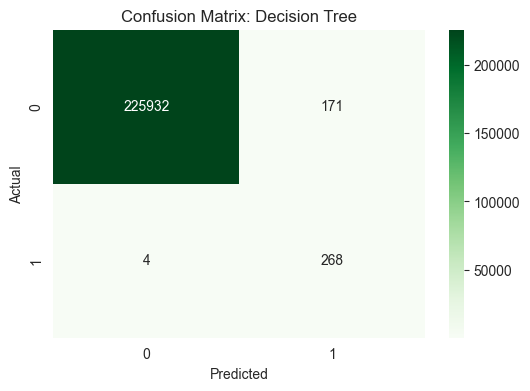

In [68]:
# Initialize Decision Tree
# We create a max_depth limit to prevent overfitting
tree_model = DecisionTreeClassifier(class_weight='balanced', random_state=42, max_depth=10)

# Training the model
print("Training Decision Tree...")
tree_model.fit(X_train_scaled, y_train)

# Prediction
y_pred_tree = tree_model.predict(X_test_scaled)

# Evaluation
print("\n===== Decision Tree Results =======")
print(classification_report(y_test, y_pred_tree))
print("AUC-ROC Score:", roc_auc_score(y_test, y_pred_tree))

# Confusion Matrix
plt.figure(figsize=(6, 4))
sns.heatmap(confusion_matrix(y_test, y_pred_tree), annot=True, fmt='d', cmap='Greens')
plt.title('Confusion Matrix: Decision Tree')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

Training XGBoost...

===== XGBoost Results =======
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    226103
           1       0.63      0.99      0.77       272

    accuracy                           1.00    226375
   macro avg       0.82      0.99      0.89    226375
weighted avg       1.00      1.00      1.00    226375

AUC-ROC Score: 0.9941403185976406


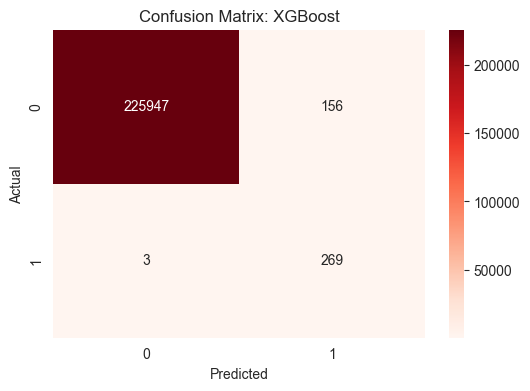

In [69]:
from xgboost import XGBClassifier

# Initialize XGBoost
# Uses scale_pos_weight to handle class imbalance automatically
scale_pos_weight = (y_train == 0).sum() / (y_train == 1).sum()
xgb_model = XGBClassifier(random_state=42, n_estimators=100, max_depth=5, learning_rate=0.1, scale_pos_weight=scale_pos_weight)

# Training the model
print("Training XGBoost...")
xgb_model.fit(X_train_scaled, y_train)

# Prediction
y_pred_xgb = xgb_model.predict(X_test_scaled)

# Evaluation
print("\n===== XGBoost Results =======")
print(classification_report(y_test, y_pred_xgb))
print("AUC-ROC Score:", roc_auc_score(y_test, y_pred_xgb))

# Confusion Matrix
plt.figure(figsize=(6, 4))
sns.heatmap(confusion_matrix(y_test, y_pred_xgb), annot=True, fmt='d', cmap='Reds')
plt.title('Confusion Matrix: XGBoost')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

Training Random Forest...

===== Random Forest Results =======
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    226103
           1       0.60      0.99      0.74       272

    accuracy                           1.00    226375
   macro avg       0.80      0.99      0.87    226375
weighted avg       1.00      1.00      1.00    226375

AUC-ROC Score: 0.9922467987650605


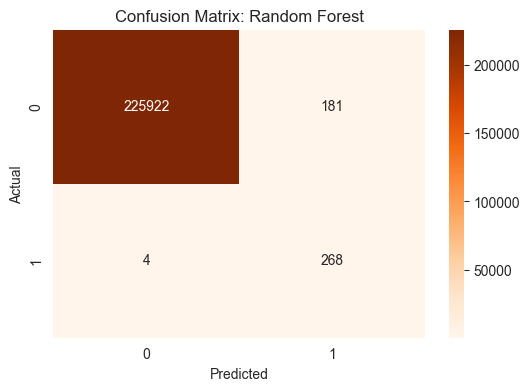

In [70]:
from sklearn.ensemble import RandomForestClassifier
# Initialize Random Forest
# We create a max_depth limit to prevent overfitting and use 100 trees
rf_model = RandomForestClassifier(class_weight='balanced', random_state=42, max_depth=10, n_estimators=100)

# Training the model
print("Training Random Forest...")
rf_model.fit(X_train_scaled, y_train)

# Prediction
y_pred_rf = rf_model.predict(X_test_scaled)

# Evaluation
print("\n===== Random Forest Results =======")
print(classification_report(y_test, y_pred_rf))
print("AUC-ROC Score:", roc_auc_score(y_test, y_pred_rf))

# Confusion Matrix
plt.figure(figsize=(6, 4))
sns.heatmap(confusion_matrix(y_test, y_pred_rf), annot=True, fmt='d', cmap='Oranges')
plt.title('Confusion Matrix: Random Forest')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

# Part 4: Clustering and Outlier Detection

### For this part, we will mainly work with the User Data, augmenenting it with additional features extracted and summarized from the transaction and fraud label datasets. Card information dataset will not be used.


### Create user dataframe - static user features + transaction summaries + fraud summarized

The cell below aggregates transactions and fraud labels per user, then merges the results with the `users` table to produce a `user_merged` dataframe containing the selected 12 features.

In [71]:
# Ensure the date column is of datetime type
df_merged['date'] = pd.to_datetime(df_merged['date'])

# convert use chip to binary
def _to_chip_binary(x):
    if isinstance(x, str):
        s = x.strip()
        if s == 'Chip Transaction':
            return 1
        if s in ('Swipe Transaction', 'Online Transaction'):
            return 0
    if x in (0, 1):
        return int(x)
  
    iv = int(x)
    if iv in (0, 1):
        return iv
    return 0

df_merged['use_chip_bin'] = df_merged['use_chip'].apply(_to_chip_binary)

# then combine the features
user_behavior = (
    df_merged
    .groupby('id')
    .agg(
        total_transactions=('id_trans', 'count'),
        first_txn_date=('date', 'min'),
        last_txn_date=('date', 'max'),
        fraud_ratio=('is_fraud', 'mean'),
        use_chip_ratio=('use_chip_bin', 'mean')
    )
    .reset_index()
)

# calculate how long each user has been active (in months)
user_behavior['months_active'] = (
    (user_behavior['last_txn_date'] - user_behavior['first_txn_date'])
    .dt.days
    .clip(lower=1) / 30
)

# compute the average number of transactions per month
user_behavior['transactions_per_month'] = (
    user_behavior['total_transactions'] / user_behavior['months_active']
)

# remove intermediate date-related columns
user_behavior = user_behavior.drop(
    columns=['first_txn_date', 'last_txn_date', 'months_active']
)

# Extract static demographic and financial user features (one row per user)
user_static = (
    df_merged
    .drop_duplicates(subset='id')  # get rid of duplicates
    [[
        'id',
        'current_age',
        'retirement_age',
        'yearly_income_clean',
        'total_debt_clean',
        'credit_score',
        'num_credit_cards',
        'latitude',
        'longitude'
    ]]
)



# merge features
user_features = pd.merge(user_behavior, user_static, on='id')
user_features = user_features.drop(columns=['total_transactions'])

# now, we scale numerical feat (BETTER BC WE WILL USE KMEANS)
features_to_scale = [
    'transactions_per_month',
    'current_age',
    'retirement_age',
    'yearly_income_clean',
    'total_debt_clean',
    'credit_score',
    'latitude', 
    'longitude'
]

# Initialize scaler
scaler = MinMaxScaler()

# Apply scaling
user_features_scaled = user_features.copy()  # keep original safe
user_features_scaled[features_to_scale] = scaler.fit_transform(user_features_scaled[features_to_scale])
# drop missing
user_features_cleaned = user_features_scaled.dropna(how='any')

print(user_features_cleaned.dtypes)


id                          int64
fraud_ratio               float64
use_chip_ratio            float64
transactions_per_month    float64
current_age               float64
retirement_age            float64
yearly_income_clean       float64
total_debt_clean          float64
credit_score              float64
num_credit_cards            int64
latitude                  float64
longitude                 float64
dtype: object


#### Checking clusterability of data

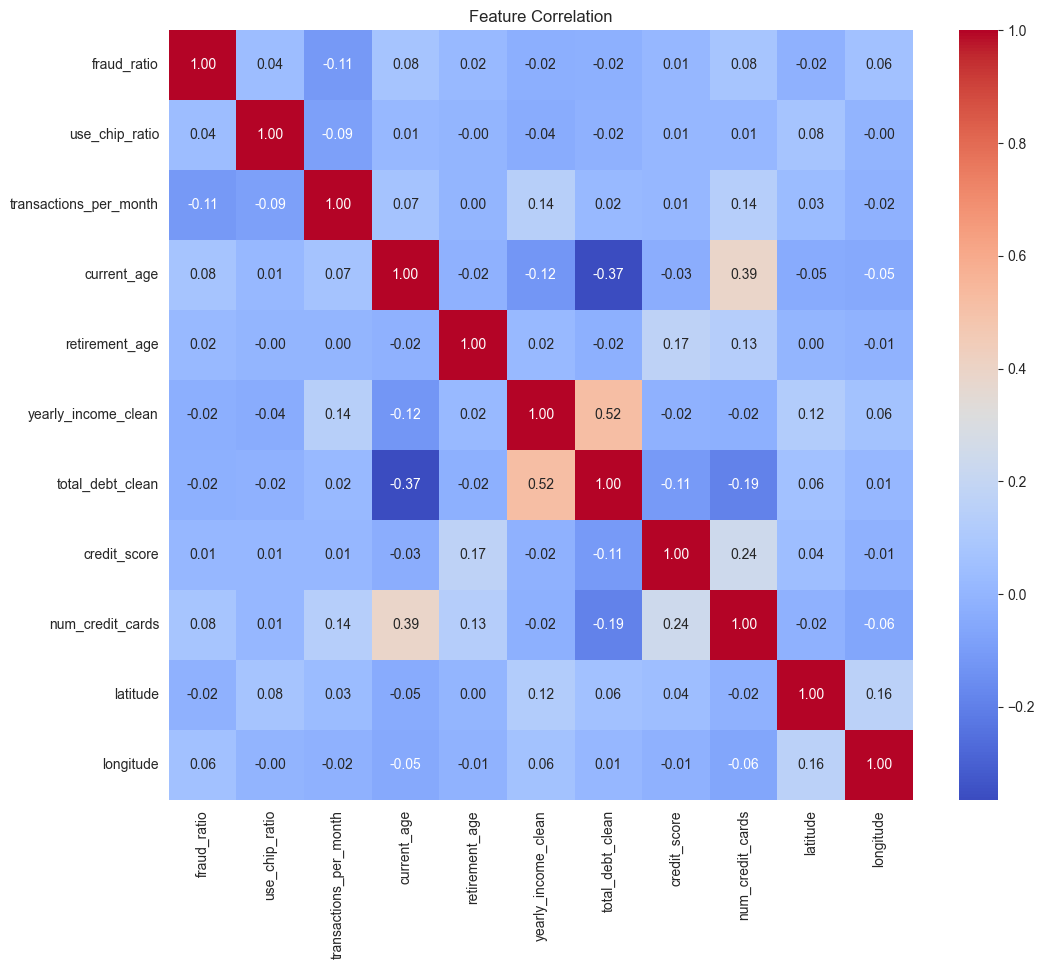

In [72]:
# Correlation heatmap, to see  how correlated the data is
plt.figure(figsize=(12,10))
sns.heatmap(user_features_cleaned.drop(columns='id').corr(), annot=True, fmt=".2f", cmap='coolwarm')
plt.title("Feature Correlation")
plt.show()

Looking at the correlation matrix, most of the features are independent from one another, making them unique. Such features aid in clusterability as it helps separate clusters from one another.

#### Applying k-means

In [73]:
# selecting the features for clustering
clustering_features = [
    'fraud_ratio',
    'use_chip_ratio',
    'transactions_per_month',
    'current_age',
    'retirement_age', 
    'yearly_income_clean',
    'total_debt_clean',
    'credit_score',
    'num_credit_cards',
    'latitude',
    'longitude'
]
X = user_features_cleaned[clustering_features].values

In [74]:
# calculating the WCSS for elbow method
wcss = []
krange = range(1, 11)
for k in krange:
    kmeans1 = KMeans(n_clusters=k, init='random', random_state=1, n_init=10)
    kmeans1.fit(X)
    wcss.append(kmeans1.inertia_)

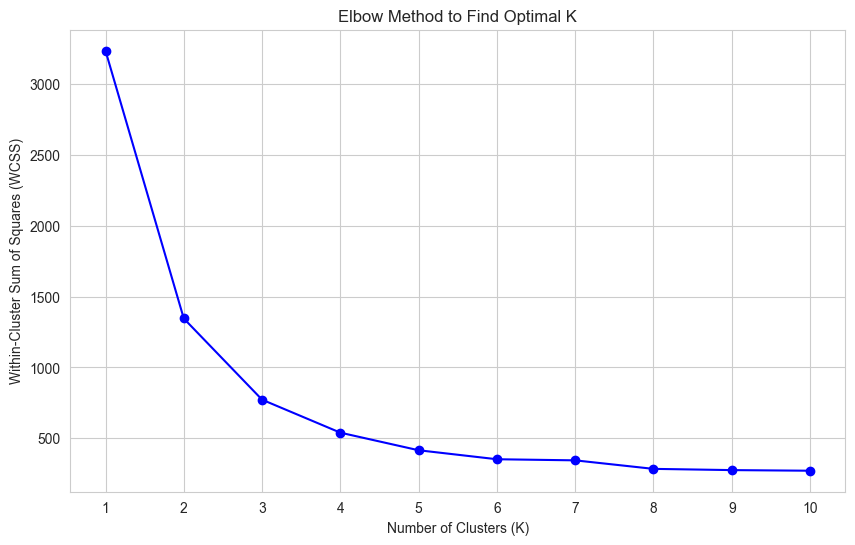

In [75]:
# plto figureee
plt.figure(figsize=(10, 6))
plt.plot(krange, wcss, marker='o', linestyle='-', color='b')
plt.title('Elbow Method to Find Optimal K')
plt.xlabel('Number of Clusters (K)')
plt.ylabel('Within-Cluster Sum of Squares (WCSS)')
plt.xticks(krange)
plt.show()

Looking at the graph, we can determine that the best number of clusters to pick is 3. Now, we will calculate the silhouette score for k from 2 to 10

In [76]:
silhouette_scores_results = {}
krange1 = range(2,11)
for k in krange1:
    # Fit the K-Means Model for the current K (using 'k-means++' for stability)
    kmeans2 = KMeans(n_clusters=k, init='random', random_state=1, n_init=10)
    kmeans2.fit(X)

    # get the labels
    cluster_labels = kmeans2.labels_

    # calc silhouette score
    score = silhouette_score(X, cluster_labels)

    #  store the score in the dictionary 
    silhouette_scores_results[k] = score

    print(f"K={k}: Silhouette Score = {score:.4f}")

K=2: Silhouette Score = 0.4835
K=3: Silhouette Score = 0.4629
K=4: Silhouette Score = 0.4278
K=5: Silhouette Score = 0.4202
K=6: Silhouette Score = 0.4432
K=7: Silhouette Score = 0.3668
K=8: Silhouette Score = 0.3854
K=9: Silhouette Score = 0.3704
K=10: Silhouette Score = 0.2999


Looking at the calculated silhouette score of 0.4629 for 3 clusters, we can determine that the clusterability of the data is Fair to Good. This indicates that our data is not just clusterable, but also clients/users are well separated into clusters. So, we will cluster the data with k=3 clusters. 

In [77]:
# fit the data
kmeans3 = KMeans(n_clusters=3, init='random', random_state=1, n_init=10)
kmeans3.fit(X)

# get the labels
final_cluster_labels = kmeans3.labels_

# add the new column that classifies each user
user_features_cleaned['kmeans_cluster_label'] = final_cluster_labels

#### Analyzing Clustering Characteristics 

In [78]:
# group data by kmeans_cluster_label and computing summary statistics
user_feat = user_features_cleaned.drop(columns='id')


#user stats
clust_stats = user_feat.groupby('kmeans_cluster_label').agg(['mean','std'])


# user count per cluster
cluster_counts = user_features_cleaned.groupby('kmeans_cluster_label').size().rename('customer_count')


# combining both
cluster_summary = pd.concat([clust_stats, cluster_counts], axis=1)
print(cluster_summary)

                      (fraud_ratio, mean)  (fraud_ratio, std)  \
kmeans_cluster_label                                            
0                                0.001726            0.003694   
1                                0.000917            0.002602   
2                                0.001370            0.003813   

                      (use_chip_ratio, mean)  (use_chip_ratio, std)  \
kmeans_cluster_label                                                  
0                                   0.713820               0.177770   
1                                   0.713072               0.243115   
2                                   0.723961               0.214964   

                      (transactions_per_month, mean)  \
kmeans_cluster_label                                   
0                                           0.219256   
1                                           0.174376   
2                                           0.190255   

                      (transactions_p

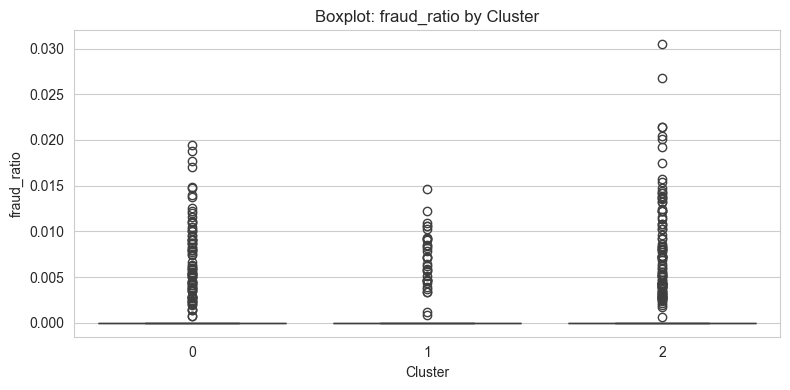

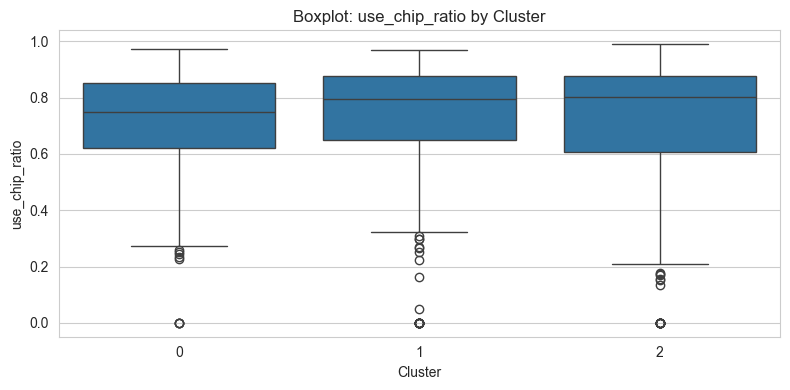

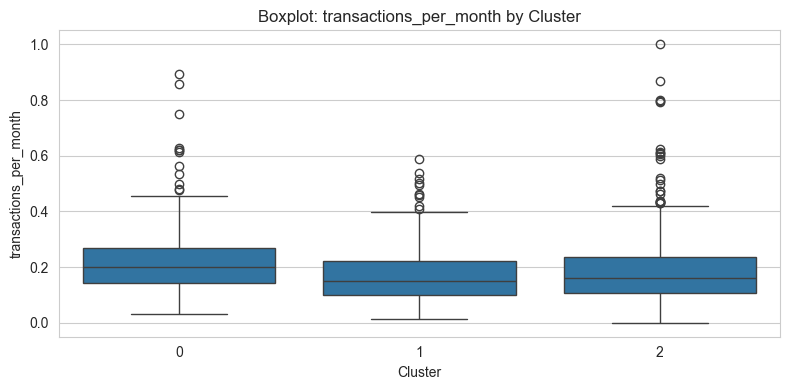

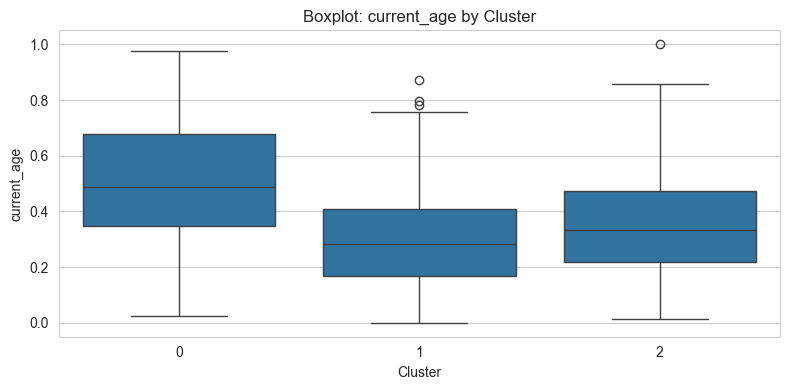

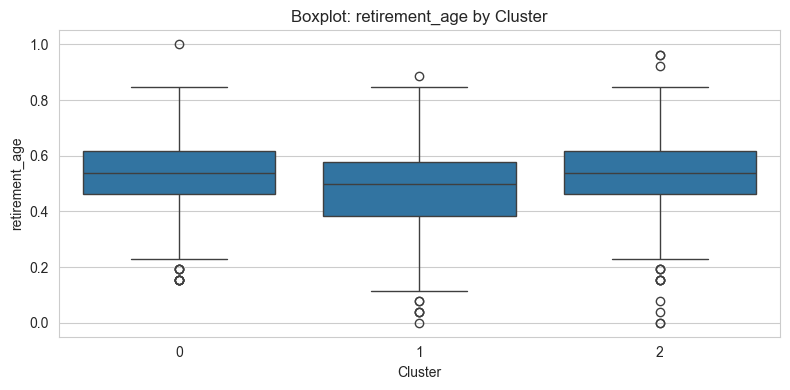

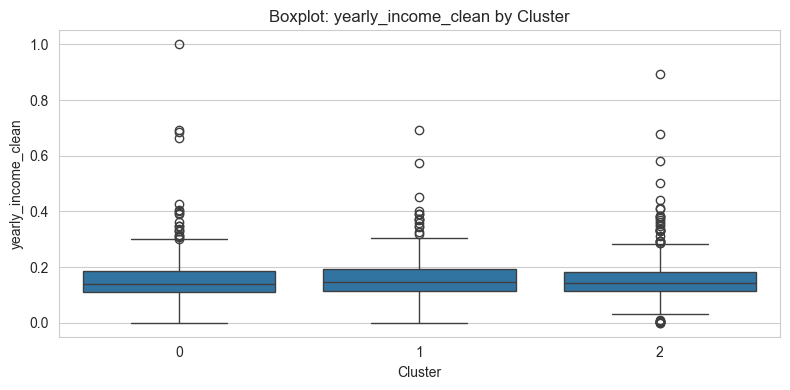

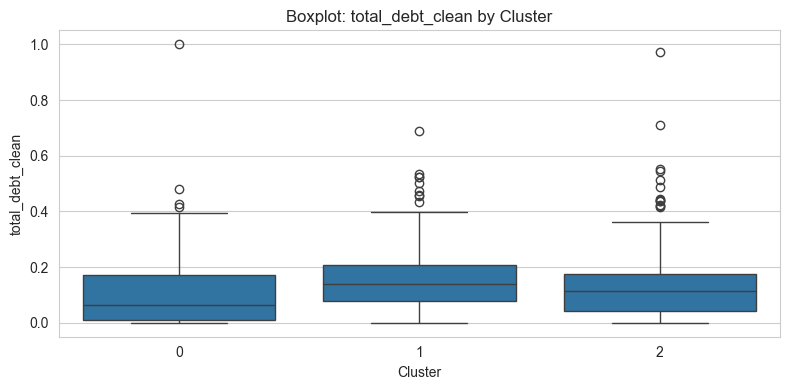

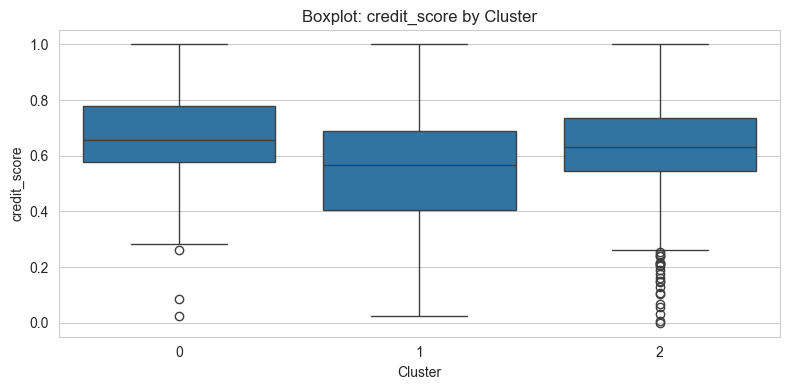

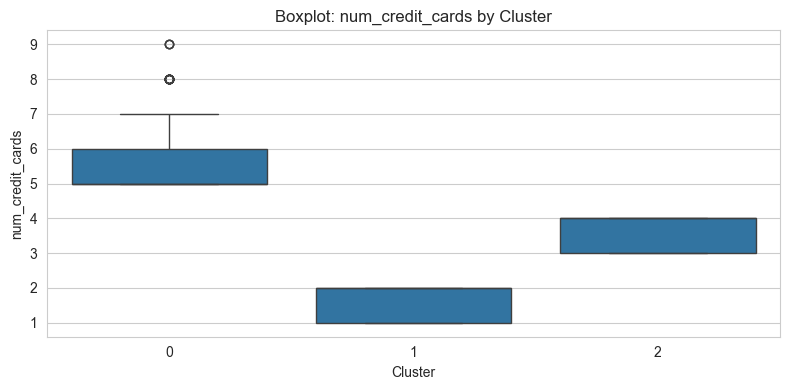

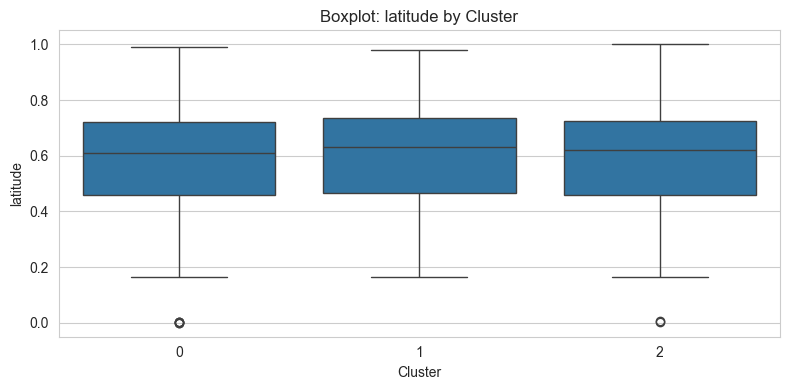

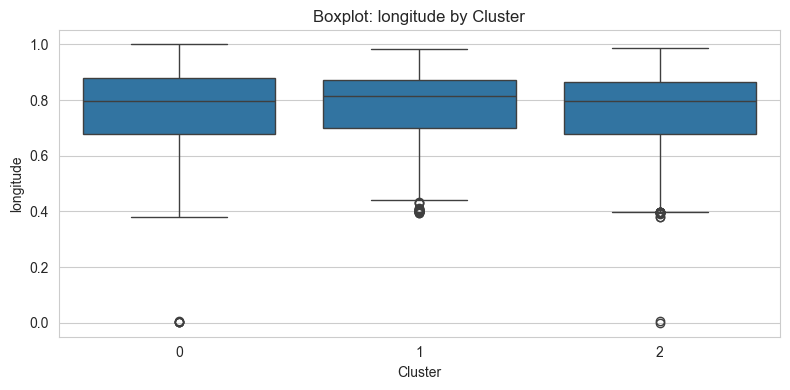

In [79]:


# using box plot to compare feature distributions
for feat in clustering_features:
    plt.figure(figsize=(8,4))
    sns.boxplot(x='kmeans_cluster_label', y=feat, data=user_features_cleaned)
    plt.title(f'Boxplot: {feat} by Cluster')
    plt.xlabel('Cluster')
    plt.ylabel(feat)
    plt.tight_layout()
    plt.show()

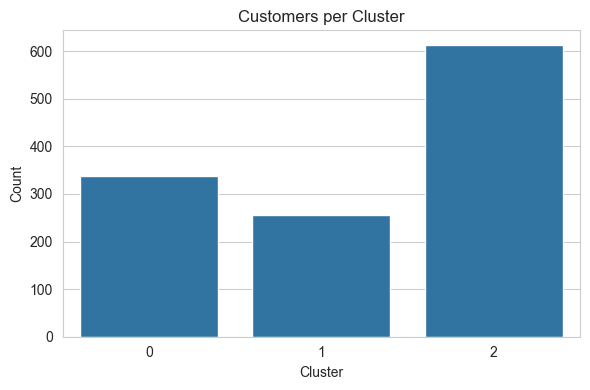

In [80]:
# count per cluster
plt.figure(figsize=(6,4))
sns.countplot(x='kmeans_cluster_label', data=user_features_cleaned)
plt.title('Customers per Cluster')
plt.xlabel('Cluster')
plt.ylabel('Count')
plt.tight_layout()
plt.show()


In [81]:
# for fraud ratio as the box plot does not help
grp = user_features_cleaned.groupby('kmeans_cluster_label')['fraud_ratio']
def outlier_count(s):
    q1 = s.quantile(0.25); q3 = s.quantile(0.75); iqr = q3 - q1
    lb, ub = q1 - 1.5*iqr, q3 + 1.5*iqr
    return ((s < lb) | (s > ub)).sum()

metrics = grp.agg(['count','mean']).rename(columns={
    'count':'users_count','mean':'mean_fraud_ratio'
})

print(metrics)


                      users_count  mean_fraud_ratio
kmeans_cluster_label                               
0                             337          0.001726
1                             256          0.000917
2                             613          0.001370


### Intepreting the Clusters

#### Cluster 0: 
Contains individuals with high financial stability and high engagement. This group contains the oldest customers and exhibits the strongest financial health, evidenced by the highest median credit scores and the least overall debt. Behaviorally, they are the most active transactors. However, this cluster carries the biggest overall fraud risk, having the highest average of fraud ratio.


#### Cluster 1: 
This cluster is characterized by financial strain and low service usage. This is the youngest segment, and while they pose the lowest historical fraud risk, they are financially vulnerable. They carry the highest total debt and have the lowest, most volatile credit scores. Their low transaction frequency indicates low engagement.


#### Cluster 2: 
This is the cluster with the largest group and the source of the most significant security concerns. This segment has moderate transactions, moderate number of cards, debt, and credit scores. However, they exhibit the second highest concentration of fraud outliers and the largest range of high-level fraud activity. 

#### Clusters that may be more vulerable to fraud

The cluster most vulnerable to fraud is Cluster 0. This is due to its highest average fraud ratio. This vulnerability is particularly concerning because Cluster 0 also contains your most financially stable and oldest customers, meaning any successful fraud attempt on this segment is likely to result in significant financial loss. The next most vulnerable segment is Cluster 2. This cluster has the second-highest average fraud ratio. In contrast, Cluster 1 is the safest cluster, exhibiting the lowest historical fraud risk.

#### Applying DBSCAN Clustering

Add a new column to your DataFrame called dbscan_label and add the cluster labels created by DBSCAN. DBSCAN assigns: A cluster number  to each point in a cluster, and a label of -1 to points that are not assigned to any cluster are considered outliers

DBSCAN Label Counts:
dbscan_label
0    1206
Name: count, dtype: int64
------------------------------
Total Outliers Detected (-1): 0
Percentage of Users labeled as Outliers: 0.00%


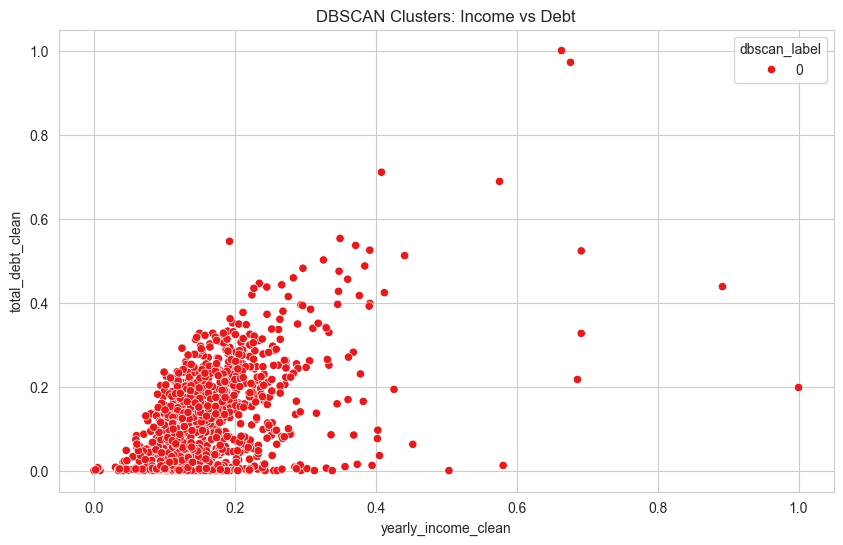

In [82]:
#Selected the same normalized features used in K-means
X_dbscan = user_features_cleaned[features_to_scale]

#Apply DBSCAN with the specified parameter eps=1.5 and min_samples=10
dbscan = DBSCAN(eps=1.5, min_samples=10)

#Fit the model and assign labels to a new column
user_features_cleaned['dbscan_label'] = dbscan.fit_predict(X_dbscan)

#Results analysis

# Count the number of outliers (Label -1)
outlier_count = (user_features_cleaned['dbscan_label'] == -1).sum()
total_points = len(user_features_cleaned)
outlier_percentage = (outlier_count / total_points) * 100

print("DBSCAN Label Counts:")
print(user_features_cleaned['dbscan_label'].value_counts())
print("-" * 30)
print(f"Total Outliers Detected (-1): {outlier_count}")
print(f"Percentage of Users labeled as Outliers: {outlier_percentage:.2f}%")

plt.figure(figsize=(10, 6))
# Scatter plot of two key features
sns.scatterplot(
    data=user_features_cleaned, 
    x='yearly_income_clean', 
    y='total_debt_clean', 
    hue='dbscan_label', 
    palette='Set1'
)
plt.title('DBSCAN Clusters: Income vs Debt')
plt.show()

The DBSCAN clustering put all 1206 users into one Class which could mean that the epsilong we applied is too high that every points is connecting to the other and making it into a big cluster. Whereas for K-means it created 3 different clusters. 


In terms of outliers, we see none based on DBSCAN, this is once again possibly because of the epsilon and min_samples assigned.

DBSCAN Label Counts:
dbscan_label
 0    1192
-1      14
Name: count, dtype: int64
------------------------------
Total Outliers Detected (-1): 14
Percentage of Users labeled as Outliers: 1.16%


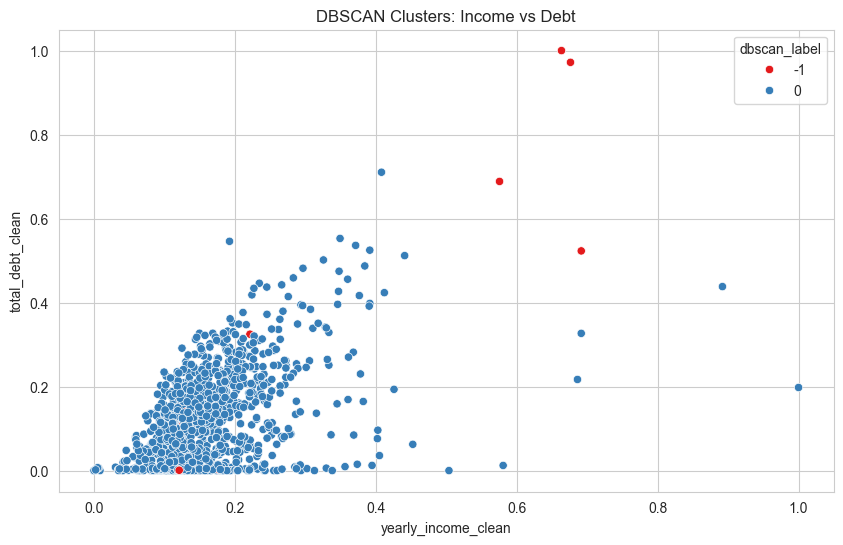

In [83]:

#Selected the same normalized features used in K-means
X_dbscan = user_features_cleaned[features_to_scale]

#Apply DBSCAN with the specified parameter eps=1.5 and min_samples=10
dbscan = DBSCAN(eps=0.5, min_samples=10)

#Fit the model and assign labels to a new column
user_features_cleaned['dbscan_label'] = dbscan.fit_predict(X_dbscan)

#Results analysis

# Count the number of outliers (Label -1)
outlier_count = (user_features_cleaned['dbscan_label'] == -1).sum()
total_points = len(user_features_cleaned)
outlier_percentage = (outlier_count / total_points) * 100

print("DBSCAN Label Counts:")
print(user_features_cleaned['dbscan_label'].value_counts())
print("-" * 30)
print(f"Total Outliers Detected (-1): {outlier_count}")
print(f"Percentage of Users labeled as Outliers: {outlier_percentage:.2f}%")

plt.figure(figsize=(10, 6))
# Scatter plot of two key features
sns.scatterplot(
    data=user_features_cleaned, 
    x='yearly_income_clean', 
    y='total_debt_clean', 
    hue='dbscan_label', 
    palette='Set1'
)
plt.title('DBSCAN Clusters: Income vs Debt')
plt.show()

We changed the epsilon to 0.5 and keeping the min_samples same as before. You can now see that it formed 1 cluster, however identified 14 outliers. 